In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/10.19')

# Preamble
## Setup of environment

In [ ]:

def rotate_and_flip(image):
    return np.fliplr(np.rot90(image, k=3))


In [ ]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 789.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19532 sha256=cd7d8275f17e35ef410178052f43a13bf2982723b5a3011bd6936704b81aae7f
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [ ]:
# imports
import os, sys

# third party imports
import random
import argparse
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nibabel as nib
# import scipy.misc
# from skimage.measure import compare_ssim
from tqdm import tqdm
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

In [ ]:
# local imports
import voxelmorph as vxm

import neurite as ne
# local/our imports
import pystrum.pynd.ndutils as nd

In [ ]:
print("nibabel version:", nib.__version__)

nibabel version: 4.0.2


---

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')

    plt.xlabel('epoch')
    plt.show()


In [ ]:
tf.__version__

'2.14.0'

In [ ]:
# pip install tensorflow-determinism

In [ ]:
# from tfdeterminism import patch

In [ ]:
# patch()
# random_seed = 7
# os.environ["PYTHONHASHSEED"] = "0"
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
# np.random.seed(random_seed)
# random.seed(random_seed)
# tf.set_random_seed(random_seed)

In [ ]:
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers


keras.utils.set_random_seed(812)



# Utils( volgen, semisupervised(data generator) , losses )

semisupervised : data generator. based on volgen funtion

It returns (invols, outvols) where      
invols = [src_vol, trg_vol, src_seg]
, outvols = [trg_vol, zeros, trg_seg]

I changed somtething in there as I use 2d imgs not 3d.
Look split_seg inside semisupervised.

In [ ]:
import sys
import glob
import numpy as np



def volgen(
    vol_names,
    batch_size=1,
    segs=None,
    np_var='vol',
    pad_shape=None,
    resize_factor=1,
    add_feat_axis=True
):
    """
    Base generator for random volume loading. Volumes can be passed as a path to
    the parent directory, a glob pattern, a list of file paths, or a list of
    preloaded volumes. Corresponding segmentations are additionally loaded if
    `segs` is provided as a list (of file paths or preloaded segmentations) or set
    to True. If `segs` is True, npz files with variable names 'vol' and 'seg' are
    expected. Passing in preloaded volumes (with optional preloaded segmentations)
    allows volumes preloaded in memory to be passed to a generator.

    Parameters:
        vol_names: Path, glob pattern, list of volume files to load, or list of
            preloaded volumes.
        batch_size: Batch size. Default is 1.
        segs: Loads corresponding segmentations. Default is None.
        np_var: Name of the volume variable if loading npz files. Default is 'vol'.
        pad_shape: Zero-pads loaded volumes to a given shape. Default is None.
        resize_factor: Volume resize factor. Default is 1.
        add_feat_axis: Load volume arrays with added feature axis. Default is True.
    """

    # convert glob path to filenames
    if isinstance(vol_names, str):
        if os.path.isdir(vol_names):
            vol_names = os.path.join(vol_names, '*')
        vol_names = glob.glob(vol_names)

    if isinstance(segs, list) and len(segs) != len(vol_names):
        raise ValueError('Number of image files must match number of seg files.')

    while True:
        # generate [batchsize] random image indices
        indices = np.random.randint(len(vol_names), size=batch_size)

        # load volumes and concatenate
        load_params = dict(np_var=np_var, add_batch_axis=True, add_feat_axis=add_feat_axis,
                           pad_shape=pad_shape, resize_factor=resize_factor)
        imgs = [vxm.py.utils.load_volfile(vol_names[i], **load_params) for i in indices]
        vols = [np.concatenate(imgs, axis=0)]

        # optionally load segmentations and concatenate
        if segs is True: ### npz 파일인 경우
            # assume inputs are npz files with 'seg' key
            load_params['np_var'] = 'seg'  # be sure to load seg
            s = [vxm.py.utils.load_volfile(vol_names[i], **load_params) for i in indices]
            vols.append(np.concatenate(s, axis=0))
        elif isinstance(segs, list): ### gz 파일인 경우
            # assume segs is a corresponding list of files or preloaded volumes
            s = [vxm.py.utils.load_volfile(segs[i], **load_params) for i in indices]
            vols.append(np.concatenate(s, axis=0))

        yield tuple(vols)

In [ ]:

def semisupervised(vol_names, seg_names, labels, atlas_file=None, downsize=2): ##seg_names = True 로 만들어야 volgen에서 npz 파일의 seg variable 불러옴
    """
    Generator for semi-supervised registration training using ground truth segmentations.
    Scan-to-atlas training can be enabled by providing the atlas_file argument.

    Parameters:
        vol_names: List of volume files to load, or list of preloaded volumes.
        seg_names: List of corresponding seg files to load, or list of preloaded volumes.
        labels: Array of discrete label values to use in training.
        atlas_file: Atlas npz file for scan-to-atlas training. Default is None.
        downsize: Downsize factor for segmentations. Default is 2.
    """
    # configure base generator
    gen = volgen(vol_names, segs=seg_names, np_var='vol')
    zeros = None

    # internal utility to generate downsampled prob seg from discrete seg
    def split_seg(seg):
    ###### vxmdense 를 위한 제너레이터에서는 세그멘테이션이 인풋으로 들어가지 않으나
    ### 나의 경우에는 인풋에 무빙, 픽스드이미지의 세그멘테이션이 들어가므로 이 함수를 통해 디스크릿한 형테의 세그멘테이션을
    ### 벡프로파게이션에서 미분 가능하도록 확률분포로 바꿔주어 들여보낸다
    ### 원레의 seg 데이터는 각 픽셀당 클래스 넘버가 지정되어있음 (1(batch),160,192) 이 셰입이지만 여기서 seg는 로드 load_vol_file을 거치며
    ### 차원이 하나 늘어서 (1, 160,192,1)임
    ### 이것을 prob_seg는 seg에서 마지막 차원 없애고 다시 차원을 하나 늘리되 그 늘려진 차원의 디멘전은 레이블 개수(4 개인데 배경포함 5개)로. (1,160,192,5)
    ### prob_seg는 각 픽셀당 다섯개클레스가 될 확률분포 예를들면 [0,0,1,0,0] 으로 저장함. (레이블이 2인 경우예시임)
    ### prob_seg[0,30,40,:] = [0,0,1,0,0] 30,40 픽셀은 레이블 2를 갖는것임. 확률분포지만 이니셜상태에서는
    ### 학습 전이므로 한 클래스가 될 확률이 100프로로 되어있음. 학습이 일어나면 0에서 1사이의 수로 바뀌게 됨
        prob_seg = np.zeros((*seg.shape[:3], len(labels))) ## (1,160,192,5) 의 제로스로 prob_seg 이니셜라이즈
        ### 즉  (1,160,192) 짜리 판(배치사이즈 무시)이 5개 생겨남.
        for i, label in enumerate(labels):
            prob_seg[0, ..., i] = seg[0, ..., 0] == label
            ### prob_seg 의 클래스 i에 해당하는 판의 각 픽셀에다가 불리안 (1,0 중 하나)를 저장할건데
            ### seg[0...0]은 seg의 첫, 마지막 디멘젼 고정하였으므로 (160,192)짜리의 판을 의미하고
            ### 그 판의 각 픽셀을 주어지 label 과 비교하여 같으면 1 다르면 0 반환
            ### 즉 그것을 prob_seg의 i번째 판에 저장하므로 결과는  (160,192) 짜리 판에 i번째 label에 해당하면 1을 갖고 아니면 0을 갖게됨
            ### 이제 prob_seg의 5개의 판은 각 레이블에 해당하는 시그멘테이션 맵이 되었고
            ### 하나의 픽셀을 고정하고 prob_seg를 출력하면 그 픽셀이 갖는 레이블이 원핫인코딩 [0,0,1,0,0] 형태로 출력됨
        return prob_seg[:, ::downsize, ::downsize,:] ##이렇게 된 프롭 세그는 다운사이즈됨.
        ### 원래는 가운데 ::downsize가 하나 더 있었는데 나는 3d가아니라 2d를 입력하므로
        ### 중간에 하나줄이고 위에 seg.shape[:4]에서 3까지로 바꿈.

    # cache target vols and segs if atlas is supplied
    if atlas_file:
        trg_vol = py.utils.load_volfile(atlas_file, np_var='vol',
                                        add_batch_axis=True, add_feat_axis=True)
        trg_seg = py.utils.load_volfile(atlas_file, np_var='seg',
                                        add_batch_axis=True, add_feat_axis=True)
        trg_seg = split_seg(trg_seg)

    while True:
        # load source vol and seg
        src_vol, src_seg = next(gen)
        src_seg = split_seg(src_seg)

        # load target vol and seg (if not provided by atlas)
        if not atlas_file:
            trg_vol, trg_seg = next(gen)
            trg_seg = split_seg(trg_seg)

        # cache zeros
        if zeros is None:
            shape = src_vol.shape[1:-1]
            zeros = np.zeros((1, *shape, len(shape)))
###########################인풋
        invols = [src_vol, trg_vol, src_seg]
        outvols = [trg_vol, zeros, trg_seg]
        yield (invols, outvols)

In [ ]:

def semisupervised_npz(vol_names, seg_names, labels, atlas_file=None, downsize=2): ##seg_names = True 로 만들어야 volgen에서 npz 파일의 seg variable 불러옴
    """
    Generator for semi-supervised registration training using ground truth segmentations.
    Scan-to-atlas training can be enabled by providing the atlas_file argument.

    Parameters:
        vol_names: List of volume files to load, or list of preloaded volumes.
        seg_names: List of corresponding seg files to load, or list of preloaded volumes.
        labels: Array of discrete label values to use in training.
        atlas_file: Atlas npz file for scan-to-atlas training. Default is None.
        downsize: Downsize factor for segmentations. Default is 2.
    """
    # configure base generator
    gen = volgen(vol_names, segs=seg_names, np_var='vol')
    zeros = None

    # internal utility to generate downsampled prob seg from discrete seg
    def split_seg(seg):
        prob_seg = np.zeros((*seg.shape[:3], len(labels))) ## (1,160,192,5) 의 제로스로 prob_seg 이니셜라이즈
        # print(f'initalized prob_seg = {prob_seg.shape}')   ==>  initalized prob_seg = (1, 160, 192, 5)
        for i, label in enumerate(labels):
            # print(f'lable = {labels.shape}') ==> lable = (5,)
            # print(f'seg =  {seg.shape}') ==> seg =  (1, 160, 192, 1, 1)
            prob_seg[0, ..., i] = seg[0, ..., 0, 0] == label ## npz 파일인 경우 세그 데이터 셰입이 (1, 160,192,1,1)이라서 마지막 두 디멘전 픽스하는것으로 수정

        return prob_seg[:, ::downsize, ::downsize,:] ##이렇게 된 프롭 세그는 다운사이즈됨.

    # cache target vols and segs if atlas is supplied
    if atlas_file:
        trg_vol = py.utils.load_volfile(atlas_file, np_var='vol',
                                        add_batch_axis=True, add_feat_axis=True)
        trg_seg = py.utils.load_volfile(atlas_file, np_var='seg',
                                        add_batch_axis=True, add_feat_axis=True)
        trg_seg = split_seg(trg_seg)

    while True:
        # load source vol and seg
        src_vol, src_seg = next(gen)
        src_seg = split_seg(src_seg)

        # load target vol and seg (if not provided by atlas)
        if not atlas_file:
            trg_vol, trg_seg = next(gen)
            trg_seg = split_seg(trg_seg)

        # cache zeros
        if zeros is None:
            shape = src_vol.shape[1:-1]
            zeros = np.zeros((1, *shape, len(shape)))
###########################인풋
        src_vol = np.squeeze(src_vol,3)
        trg_vol = np.squeeze(trg_vol,3)
        invols = [src_vol, trg_vol, src_seg]
        outvols = [trg_vol, zeros, trg_seg]
        yield (invols, outvols)

In [ ]:


# core python
import sys
import warnings

# third party
import numpy as np
import neurite as ne
import tensorflow as tf
import tensorflow.keras.backend as K


class NCC:
    """
    Local (over window) normalized cross correlation loss.
    """

    def __init__(self, win=None, eps=1e-5, signed=False):
        self.win = win
        self.eps = eps
        self.signed = signed

    def ncc(self, Ii, Ji):
        # get dimension of volume
        # assumes Ii, Ji are sized [batch_size, *vol_shape, nb_feats]
        ndims = len(Ii.get_shape().as_list()) - 2
        assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

        # set window size
        if self.win is None:
            self.win = [9] * ndims
        elif not isinstance(self.win, list):  # user specified a single number not a list
            self.win = [self.win] * ndims

        # get convolution function
        conv_fn = getattr(tf.nn, 'conv%dd' % ndims)

        # compute CC squares
        I2 = Ii * Ii
        J2 = Ji * Ji
        IJ = Ii * Ji

        # compute filters
        in_ch = Ji.get_shape().as_list()[-1]
        # sum_filt = tf.ones([*self.win, in_ch, 1])
        sum_filt = tf.ones([*self.win, in_ch, 1], dtype=Ii.dtype)
        strides = 1
        if ndims > 1:
            strides = [1] * (ndims + 2)

        # compute local sums via convolution
        padding = 'SAME'
        I_sum = conv_fn(Ii, sum_filt, strides, padding)
        J_sum = conv_fn(Ji, sum_filt, strides, padding)
        I2_sum = conv_fn(I2, sum_filt, strides, padding)
        J2_sum = conv_fn(J2, sum_filt, strides, padding)
        IJ_sum = conv_fn(IJ, sum_filt, strides, padding)

        # compute cross correlation
        win_size = np.prod(self.win) * in_ch
        u_I = I_sum / win_size
        u_J = J_sum / win_size

        # TODO: simplify this
        cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
        cross = tf.maximum(cross, self.eps)
        I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
        I_var = tf.maximum(I_var, self.eps)
        J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size
        J_var = tf.maximum(J_var, self.eps)

        if self.signed:
            cc = cross / tf.sqrt(I_var * J_var + self.eps)
        else:
            # cc = (cross * cross) / (I_var * J_var)
            cc = (cross / I_var) * (cross / J_var)

        return cc

    def loss(self, y_true, y_pred, reduce='mean'):
        # compute cc
        cc = self.ncc(y_true, y_pred)
        # reduce
        if reduce == 'mean':
            cc = tf.reduce_mean(K.batch_flatten(cc), axis=-1)
        elif reduce == 'max':
            cc = tf.reduce_max(K.batch_flatten(cc), axis=-1)
        elif reduce is not None:
            raise ValueError(f'Unknown NCC reduction type: {reduce}')
        # loss
        return -cc


class MSE:
    """
    Sigma-weighted mean squared error for image reconstruction.
    """

    def __init__(self, image_sigma=1.0):
        self.image_sigma = image_sigma

    def mse(self, y_true, y_pred):
        return K.square(y_true - y_pred)

    def loss(self, y_true, y_pred, reduce='mean'):
        # compute mse
        mse = self.mse(y_true, y_pred)
        # reduce
        if reduce == 'mean':
            mse = K.mean(mse)
        elif reduce == 'max':
            mse = K.max(mse)
        elif reduce is not None:
            raise ValueError(f'Unknown MSE reduction type: {reduce}')
        # loss
        return 1.0 / (self.image_sigma ** 2) * mse


class TukeyBiweight:
    """
    Tukey-Biweight loss.

    The single parameter c represents the threshold above which voxel
    differences are cropped and have no further effect (that is, they are
    treated as outliers and automatically discounted).

    See: DOI: 10.1016/j.neuroimage.2010.07.020
    Reuter, Rosas and Fischl, 2010. Highly accurate inverse consistent registration:
    a robust approach. NeuroImage, 53(4):1181-96.
    """

    def __init__(self, c=0.5):
        self.csq = c * c  # squared error threshold

    def loss(self, y_true, y_pred):
        error_sq = (y_true - y_pred) ** 2
        mask_below = tf.cast((error_sq <= self.csq), tf.float32)
        rho_above = tf.cast((error_sq > self.csq), tf.float32) * self.csq / 2

        rho_below = (self.csq / 2) * (1 - ((1 - ((error_sq * mask_below) / self.csq)) ** 3))
        rho = rho_above + rho_below

        return tf.reduce_mean(rho)

class Zero:
    def loss(self, y_true, y_pred):
        return 0
class Dice:
    """
    N-D dice for segmentation
    """

    def loss(self, y_true, y_pred):
        ndims = len(y_pred.get_shape().as_list()) - 2
        vol_axes = list(range(1, ndims + 1))

        top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
        bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

        div_no_nan = tf.math.divide_no_nan if hasattr(
            tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
        dice = tf.reduce_mean(div_no_nan(top, bottom))
        return -dice

class LC_Dice:
    """
    N-D dice for segmentation
    """

    def loss(self, y_true, y_pred):
        ndims = len(y_pred.get_shape().as_list()) - 2
        vol_axes = list(range(1, ndims + 1))

        top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
        bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

        div_no_nan = tf.math.divide_no_nan if hasattr(
            tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
        dice = tf.reduce_mean(div_no_nan(top, bottom))
        # return -np.cosh(np.log(dice))
        return -tf.math.log((tf.exp(dice) + tf.exp(-dice)) / 2.0)


class F_beta:

    def __init__(self, beta = 1): # beta = 0 이면 f1 즉 dice 와 동일함
        self.beta = beta
    def loss(self, y_true, y_pred):
        ndims = len(y_pred.get_shape().as_list()) - 2
        vol_axes = list(range(1, ndims + 1))

        top = (1+self.beta**2) * tf.reduce_sum(y_true * y_pred, vol_axes)
        bottom = tf.reduce_sum((self.beta**2)*y_true + y_pred, vol_axes)

        div_no_nan = tf.math.divide_no_nan if hasattr(
            tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
        dice = tf.reduce_mean(div_no_nan(top, bottom))
        return -dice

class Simm:
    def loss(self, y_true, y_pred):
      """
      Structural Similarity Index (SSIM) loss
      """
      return 1 - tf.image.ssim(y_true, y_pred, max_val=1)


class Grad:
    """
    N-D gradient loss.
    loss_mult can be used to scale the loss value - this is recommended if
    the gradient is computed on a downsampled vector field (where loss_mult
    is equal to the downsample factor).
    """

    def __init__(self, penalty='l1', loss_mult=None, vox_weight=None):
        self.penalty = penalty
        self.loss_mult = loss_mult
        self.vox_weight = vox_weight

    def _diffs(self, y):
        vol_shape = y.get_shape().as_list()[1:-1]
        ndims = len(vol_shape)

        df = [None] * ndims
        for i in range(ndims):
            d = i + 1
            # permute dimensions to put the ith dimension first
            r = [d, *range(d), *range(d + 1, ndims + 2)]
            yp = K.permute_dimensions(y, r)
            dfi = yp[1:, ...] - yp[:-1, ...]

            if self.vox_weight is not None:
                w = K.permute_dimensions(self.vox_weight, r)
                # TODO: Need to add square root, since for non-0/1 weights this is bad.
                dfi = w[1:, ...] * dfi

            # permute back
            # note: this might not be necessary for this loss specifically,
            # since the results are just summed over anyway.
            r = [*range(1, d + 1), 0, *range(d + 1, ndims + 2)]
            df[i] = K.permute_dimensions(dfi, r)

        return df

    def loss(self, _, y_pred):
        """
        returns Tensor of size [bs]
        """

        if self.penalty == 'l1':
            dif = [tf.abs(f) for f in self._diffs(y_pred)]
        else:
            assert self.penalty == 'l2', 'penalty can only be l1 or l2. Got: %s' % self.penalty
            dif = [f * f for f in self._diffs(y_pred)]

        df = [tf.reduce_mean(K.batch_flatten(f), axis=-1) for f in dif]
        grad = tf.add_n(df) / len(df)

        if self.loss_mult is not None:
            grad *= self.loss_mult

        return grad

    def mean_loss(self, y_true, y_pred):
        """
        returns Tensor of size ()
        """

        return K.mean(self.loss(y_true, y_pred))


class KL:
    """
    Kullback–Leibler divergence for probabilistic flows.
    """

    def __init__(self, prior_lambda, flow_vol_shape):
        self.prior_lambda = prior_lambda
        self.flow_vol_shape = flow_vol_shape
        self.D = None

    def _adj_filt(self, ndims):
        """
        compute an adjacency filter that, for each feature independently,
        has a '1' in the immediate neighbor, and 0 elsewhere.
        so for each filter, the filter has 2^ndims 1s.
        the filter is then setup such that feature i outputs only to feature i
        """

        # inner filter, that is 3x3x...
        filt_inner = np.zeros([3] * ndims)
        for j in range(ndims):
            o = [[1]] * ndims
            o[j] = [0, 2]
            filt_inner[np.ix_(*o)] = 1

        # full filter, that makes sure the inner filter is applied
        # ith feature to ith feature
        filt = np.zeros([3] * ndims + [ndims, ndims])
        for i in range(ndims):
            filt[..., i, i] = filt_inner

        return filt

    def _degree_matrix(self, vol_shape):
        # get shape stats
        ndims = len(vol_shape)
        sz = [*vol_shape, ndims]

        # prepare conv kernel
        conv_fn = getattr(tf.nn, 'conv%dd' % ndims)

        # prepare tf filter
        z = K.ones([1] + sz)
        filt_tf = tf.convert_to_tensor(self._adj_filt(ndims), dtype=tf.float32)
        strides = [1] * (ndims + 2)
        return conv_fn(z, filt_tf, strides, "SAME")

    def prec_loss(self, y_pred):
        """
        a more manual implementation of the precision matrix term
                mu * P * mu    where    P = D - A
        where D is the degree matrix and A is the adjacency matrix
                mu * P * mu = 0.5 * sum_i mu_i sum_j (mu_i - mu_j) = 0.5 * sum_i,j (mu_i - mu_j) ^ 2
        where j are neighbors of i

        Note: could probably do with a difference filter,
        but the edges would be complicated unless tensorflow allowed for edge copying
        """
        vol_shape = y_pred.get_shape().as_list()[1:-1]
        ndims = len(vol_shape)

        sm = 0
        for i in range(ndims):
            d = i + 1
            # permute dimensions to put the ith dimension first
            r = [d, *range(d), *range(d + 1, ndims + 2)]
            y = K.permute_dimensions(y_pred, r)
            df = y[1:, ...] - y[:-1, ...]
            sm += K.mean(df * df)

        return 0.5 * sm / ndims

    def loss(self, y_true, y_pred):
        """
        KL loss
        y_pred is assumed to be D*2 channels: first D for mean, next D for logsigma
        D (number of dimensions) should be 1, 2 or 3

        y_true is only used to get the shape
        """

        # prepare inputs
        ndims = len(y_pred.get_shape()) - 2
        mean = y_pred[..., 0:ndims]
        log_sigma = y_pred[..., ndims:]

        # compute the degree matrix (only needs to be done once)
        # we usually can't compute this until we know the ndims,
        # which is a function of the data
        if self.D is None:
            self.D = self._degree_matrix(self.flow_vol_shape)

        # sigma terms
        sigma_term = self.prior_lambda * self.D * tf.exp(log_sigma) - log_sigma
        sigma_term = K.mean(sigma_term)

        # precision terms
        # note needs 0.5 twice, one here (inside self.prec_loss), one below
        prec_term = self.prior_lambda * self.prec_loss(mean)

        # combine terms
        # ndims because we averaged over dimensions as well
        return 0.5 * ndims * (sigma_term + prec_term)


class MutualInformation(ne.metrics.MutualInformation):
    """
    Soft Mutual Information approximation for intensity volumes

    More information/citation:
    - Courtney K Guo.
      Multi-modal image registration with unsupervised deep learning.
      PhD thesis, Massachusetts Institute of Technology, 2019.
    - M Hoffmann, B Billot, DN Greve, JE Iglesias, B Fischl, AV Dalca
      SynthMorph: learning contrast-invariant registration without acquired images
      IEEE Transactions on Medical Imaging (TMI), 41 (3), 543-558, 2022
      https://doi.org/10.1109/TMI.2021.3116879
    """

    def loss(self, y_true, y_pred):
        return -self.volumes(y_true, y_pred)






#Data(nii.gz)

In [ ]:
# #랩로테이션 폴더에 다운한번받았으니 이제 안받아도됨

# # Neurite-OASIS 데이터 다운로드
# !wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar

# # OASIS 디렉토리 생성 및 데이터 압축 해제
# !mkdir OASIS
# !tar xf neurite-oasis.2d.v1.0.tar --directory 'OASIS'




In [ ]:
# # download MRI tutorial data
# !wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
# !tar -xzvf data.tar.gz

In [ ]:
# OASIS 데이터 디렉토리에서 MR1 파일들의 경로를 추출하여 학습용 파일 리스트 생성



import pathlib

# OASIS 데이터 디렉토리 경로 설정
path = pathlib.Path('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS')
# path = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS')

# MR1 파일에 해당하는 slice_norm.nii.gz 파일들의 경로 추출
data_imgs = [str(f/'slice_norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]
data_segs = [str(f/'slice_seg4.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]

print(len(data_imgs))



# 추출한 파일 경로들을 'train_list.txt' ,'train_list_seg.txt'파일에 작성 350까지트레인 나머지 발리
with open('train_list.txt', 'w') as tfile:
    tfile.write('\n'.join(data_imgs[:350]))

with open('val_list.txt', 'w') as tfile:
    tfile.write('\n'.join(data_imgs[350:]))

with open('train_list_seg.txt', 'w') as tfile:
    tfile.write('\n'.join(data_segs[:350]))

with open('val_list_seg.txt', 'w') as tfile:
    tfile.write('\n'.join(data_segs[350:]))

414


(160, 192, 1)
(160, 192, 1)
(160, 192, 1)
(160, 192, 1)
(160, 192, 1)


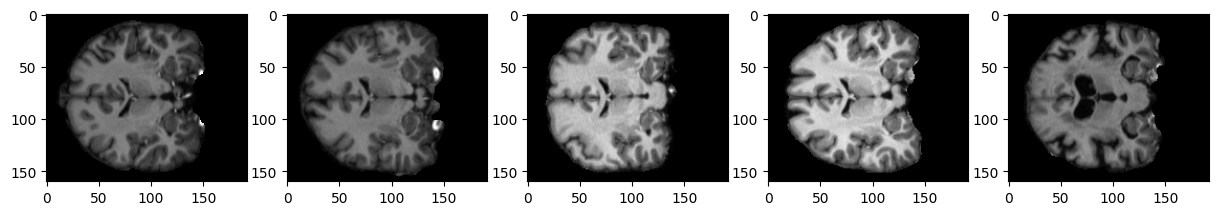

(160, 192, 1)
(160, 192, 1)
(160, 192, 1)
(160, 192, 1)
(160, 192, 1)


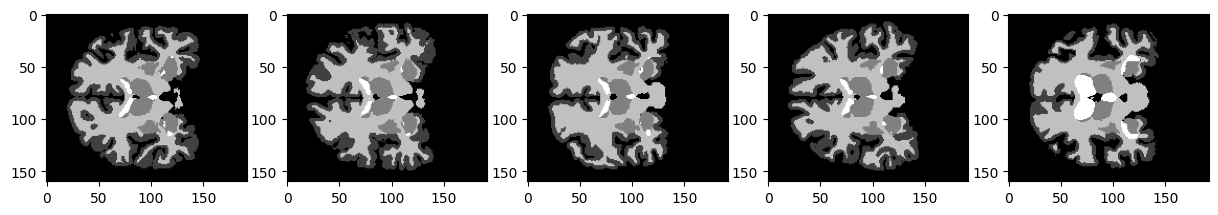

In [ ]:
### load train imgs, segs
### shapes: both (160,192,1)

# 'train_list.txt' 파일에서 이미지 파일 경로들을 읽어옴
with open('train_list.txt', 'r') as tfile:
    train_imgs = tfile.read().splitlines() # 트레인셋 볼륨(이미지) 데이터
with open('train_list_seg.txt', 'r') as tfile:
    train_segs = tfile.read().splitlines() # 트레인세 세그멘테이션 데이터

# 처음 몇 개의 이미지를 로드하고 표시
num_images_to_show = 5  # 표시할 이미지 개수 설정


fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))
for i, img_path in enumerate(train_imgs[:num_images_to_show]):
    img_data = nib.load(img_path).get_fdata()
    print(img_data.shape)#(160, 192, 1)
    axes[i].imshow(img_data, cmap='gray')  # Change indexing to [:, :, i]

plt.show()

fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))
for i, img_path in enumerate(train_segs[:num_images_to_show]):
    img_data = nib.load(img_path).get_fdata()
    print(img_data.shape)
    axes[i].imshow(img_data, cmap='gray')  # Change indexing to [:, :, i]

plt.show()


In [ ]:
## Make labels array
## labels_array_str = array(['Unknown', 'Cortex', 'Subcortical-Gray-Matter', 'White-Matter', 'CSF'], dtype='<U23')
## labels_array = [0,1,2,3,4] : this form has to be fed into generator not the string version

# Load data from the txt file (skipping lines starting with '#' and empty lines)
labels = []
with open('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS/seg4_labels.txt', 'r') as txt_file:
# with open('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS/seg4_labels.txt', 'r') as txt_file:
    lines = txt_file.readlines()
    for line in lines:
        if not line.startswith('#') and line.strip():
            parts = line.split()
            label = ' '.join(parts[1:-4])  # Extract label name
            labels.append(label)

# Convert the list of labels to a numpy array
labels_array_str = np.array(labels)

# Save the numpy array as an npy file
np.save('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS/seg4_labels.npy', labels_array_str)
# np.save('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS/seg4_labels.npy', labels_array_str)

labels_array_str

labels_array_nr = np.array([0, 1, 2, 3, 4]) ##

0.4627451
(1, 160, 192, 1)
(1, 160, 192, 1)
(1, 80, 96, 5)
(1, 80, 96, 5)
[1. 0. 0. 0. 0.]


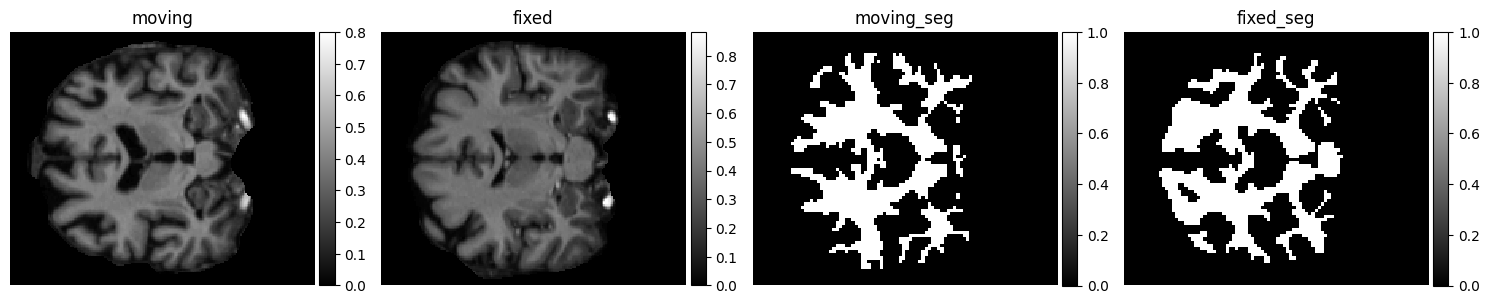

In [ ]:

generator = semisupervised(
    train_imgs, train_segs, labels = labels_array_nr)
## 처음엔 여기에 labels_array_str넣었는데 그랬더니 에러는 안나지만 세그멘테이션 데이터가 다 0으로 나옴
## 이유는 semisupervised에

print(np.max(next(generator)[0][0])) ## 모든데이터가 0이 아님을 확인
print(next(generator)[0][0].shape) # 소스이미지src_vol
print(next(generator)[1][0].shape) # 타겟이미지trg_vol
print(next(generator)[0][2].shape) # 소스세그멘테이션 맵 (b,h,w,5) 반으로 다운사이즈됨 src_seg
print(next(generator)[1][2].shape) # 탙겟세그멘테이션 맵 반으로 다운사이즈됨 trg_seg

images = [np.squeeze(next(generator)[0][0]),np.squeeze(next(generator)[1][0]),np.squeeze(next(generator)[0][2][:,:,:,3]),np.squeeze(next(generator)[1][2][:,:,:,3])]
### 편의상 3번째 시그멘테이션만 출력함. 시그맨테이션 순서 [배경, 1,2,3,4]
print(np.squeeze(next(generator)[0][2][0,40,35,:])) ## 40,70 픽셀은 어떤 클래스에 해당되는지 확률분포로 출력
##여기에서는 [0. 0. 0. 1. 0.] 로 출력되므로 세번째 레이블(배경)에 속할 가능성이 100프로다는 뜻
titles = ['moving', 'fixed', 'moving_seg', 'fixed_seg']
ne.plot.slices(images, titles = titles, cmaps=['gray'], do_colorbars=True);


# Data(npz)

In [ ]:
# #랩로테이션 폴더에 다운한번받았으니 이제 안받아도됨

# # Neurite-OASIS 데이터 다운로드
# !wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar

# # OASIS 디렉토리 생성 및 데이터 압축 해제
# !mkdir OASIS
# !tar xf neurite-oasis.2d.v1.0.tar --directory 'OASIS' ##일단 여기에 받고

# # OASIS 디렉토리 생성 및 데이터 압축 해제
# !mkdir OASIS_npz
# !tar xf neurite-oasis.2d.v1.0.tar --directory 'OASIS_npz' ##npz로 변경


In [ ]:
##이미 드라이브에 저장되어있음

# ## nii.gz로 저장되어있는 데이터를 npz로 변경
# data_dir = "/content/drive/MyDrive/Colab Notebooks/10.19/OASIS"  # OASIS 데이터 디렉토리 경로
# output_dir = "/content/drive/MyDrive/Colab Notebooks/10.19/OASIS_npz"  # npz 파일을 저장할 디렉토리 경로

# # 하위 폴더들의 목록을 가져옴
# sub_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

# for folder in sub_folders:
#     # 각 폴더 내에서 해당하는 gz 파일들의 경로를 추출
#     norm_path = os.path.join(data_dir, folder, 'slice_norm.nii.gz')
#     orig_path = os.path.join(data_dir, folder, 'slice_orig.nii.gz')
#     seg4_path = os.path.join(data_dir, folder, 'slice_seg4.nii.gz')
#     seg24_path = os.path.join(data_dir, folder, 'slice_seg24.nii.gz')

#     # 파일들을 읽어와서 데이터로 변환
#     norm_data = nib.load(norm_path).get_fdata()
#     orig_data = nib.load(orig_path).get_fdata()
#     seg4_data = nib.load(seg4_path).get_fdata()
#     seg24_data = nib.load(seg24_path).get_fdata()

#     # 저장할 npz 파일명
#     npz_filename = os.path.join(output_dir, f"{folder}.npz")

#     # 데이터를 npz 파일로 저장
#     np.savez(npz_filename, vol=norm_data, orig=orig_data, seg=seg4_data, seg24=seg24_data)

# print("Conversion completed.")


['OASIS_OAS1_0032_MR1.npz', 'OASIS_OAS1_0033_MR1.npz', 'OASIS_OAS1_0034_MR1.npz', 'OASIS_OAS1_0035_MR1.npz', 'OASIS_OAS1_0037_MR1.npz', 'OASIS_OAS1_0047_MR1.npz', 'OASIS_OAS1_0055_MR1.npz', 'OASIS_OAS1_0056_MR1.npz', 'OASIS_OAS1_0060_MR1.npz', 'OASIS_OAS1_0061_MR1.npz', 'OASIS_OAS1_0062_MR1.npz', 'OASIS_OAS1_0064_MR1.npz', 'OASIS_OAS1_0065_MR1.npz', 'OASIS_OAS1_0070_MR1.npz', 'OASIS_OAS1_0071_MR1.npz', 'OASIS_OAS1_0072_MR1.npz', 'OASIS_OAS1_0073_MR1.npz', 'OASIS_OAS1_0074_MR1.npz', 'OASIS_OAS1_0076_MR1.npz', 'OASIS_OAS1_0078_MR1.npz', 'OASIS_OAS1_0080_MR1.npz', 'OASIS_OAS1_0081_MR1.npz', 'OASIS_OAS1_0083_MR1.npz', 'OASIS_OAS1_0084_MR1.npz', 'OASIS_OAS1_0087_MR1.npz', 'OASIS_OAS1_0104_MR1.npz', 'OASIS_OAS1_0106_MR1.npz', 'OASIS_OAS1_0113_MR1.npz', 'OASIS_OAS1_0116_MR1.npz', 'OASIS_OAS1_0119_MR1.npz', 'OASIS_OAS1_0133_MR1.npz', 'OASIS_OAS1_0135_MR1.npz', 'OASIS_OAS1_0143_MR1.npz', 'OASIS_OAS1_0146_MR1.npz', 'OASIS_OAS1_0147_MR1.npz', 'OASIS_OAS1_0148_MR1.npz', 'OASIS_OAS1_0152_MR1.npz', 

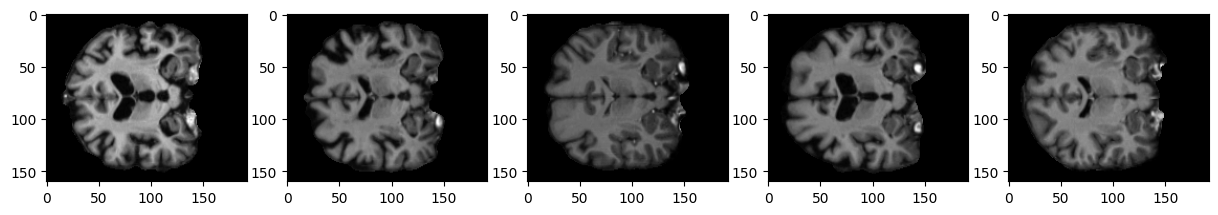

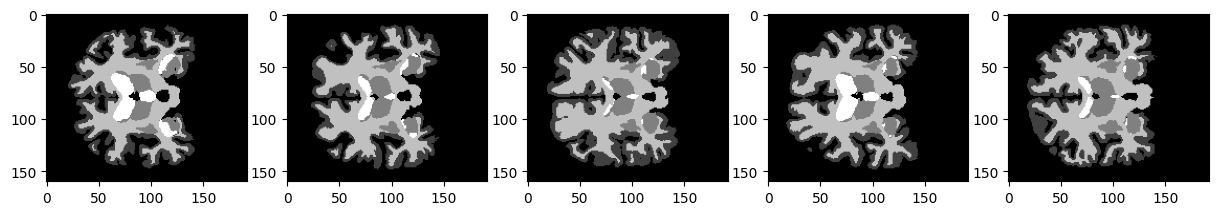

In [ ]:

# OASIS 데이터 디렉토리에서 MR1 파일들의 경로를 추출하여 학습용 파일 리스트 생성
# npz 파일은 딕셔너리 형태. 현재 키 : vol, org, seg, seg24
# 벨류는 차례로 볼륨파일(정규화된버전), 원본볼륨, 세그멘테이션4개로 된것, 24개로 된것
# 현재 세그멘테이션 셰입은 볼륨 셰입과 동일한 (160, 192, 1) 즉 각 픽셀당 레이블 0,1,2,3 할당되어있음.

import pathlib

# OASIS 데이터 디렉토리 경로 설정
path_npz = pathlib.Path('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS_npz')
# path_npz = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS_npz')

# npz 파일들의 목록을 가져옴
npz_files = [f for f in os.listdir(path_npz) if f.endswith('MR1.npz')]


print(npz_files)

# norm 이미지를 가져와서 표시
npz_list = []
for i, npz_file in enumerate(npz_files):
    npz_list.append(os.path.join(path_npz, npz_file))
print(npz_list)
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))
for i, npz_file in enumerate(npz_files[:5]):
    npz_data = np.load(os.path.join(path_npz, npz_file))
    # print(npz_data['vol'].shape)
    axes[i].imshow(npz_data['vol'], cmap='gray')
plt.show()

# seg 이미지를 가져와서 표시
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))
for i, npz_file in enumerate(npz_files[:5]):
    npz_data = np.load(os.path.join(path_npz, npz_file))
    # print(np.unique(npz_data['seg']))
    axes[i].imshow(npz_data['seg'], cmap='gray')
plt.show()


0.47058823704719543
(1, 160, 192, 1)
(1, 160, 192, 1)
(1, 80, 96, 5)
(1, 80, 96, 5)
[0. 0. 0. 1. 0.]


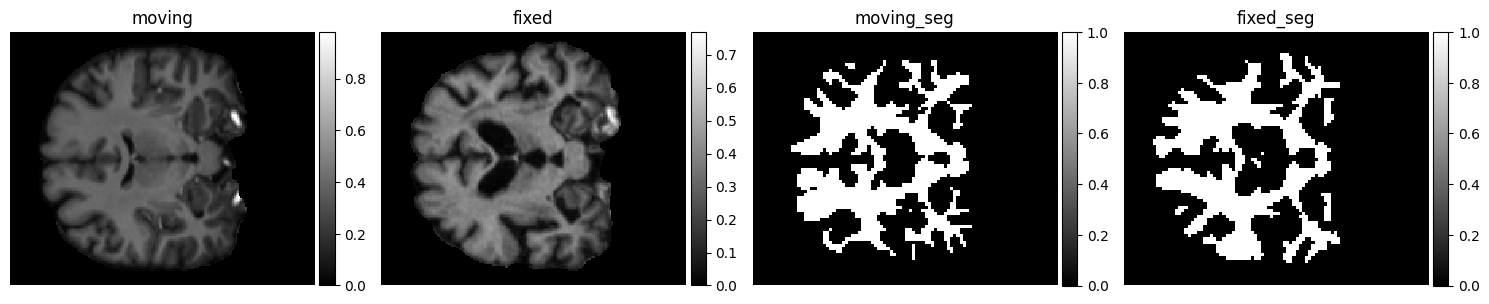

In [ ]:
## data generator
train_imgs = '/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS_npz'
# train_imgs = '//content/drive/MyDrive/Colab Notebooks/10.19/OASIS_npz'
train_segs = True ##이렇게 하면 자동으로 키가 seg 인것을 불러옴. 현재는 seg4 데이터가 가 seg에 저장되어있음


generator = semisupervised_npz(
    npz_list, train_segs, labels = labels_array_nr)
## 처음엔 여기에 labels_array_str넣었는데 그랬더니 에러는 안나지만 세그멘테이션 데이터가 다 0으로 나옴
## 이유는 semisupervised에

print(np.max(next(generator)[0][0])) ## 모든데이터가 0이 아님을 확인
print(next(generator)[0][0].shape) # 소스이미지src_vol
print(next(generator)[1][0].shape) # 타겟이미지trg_vol
print(next(generator)[0][2].shape) # 소스세그멘테이션 맵 (b,h,w,5) 반으로 다운사이즈됨 src_seg
print(next(generator)[1][2].shape) # 탙겟세그멘테이션 맵 반으로 다운사이즈됨 trg_seg

images = [np.squeeze(next(generator)[0][0]),np.squeeze(next(generator)[1][0]),np.squeeze(next(generator)[0][2][:,:,:,3]),np.squeeze(next(generator)[1][2][:,:,:,3])]
### 편의상 3번째 시그멘테이션만 출력함. 시그맨테이션 순서 [배경, 1,2,3,4]
print(np.squeeze(next(generator)[0][2][0,40,35,:])) ## 40,70 픽셀은 어떤 클래스에 해당되는지 확률분포로 출력
##여기에서는 [0. 0. 0. 1. 0.] 로 출력되므로 세번째 레이블(배경)에 속할 가능성이 100프로다는 뜻
titles = ['moving', 'fixed', 'moving_seg', 'fixed_seg']
ne.plot.slices(images, titles = titles, cmaps=['gray'], do_colorbars=True);


# Train


## F_beta train

In [ ]:
# 실험 베타 값 리스트
train_labels = np.load('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS/seg4_labels.npy')
# train_labels = np.load('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS/seg4_labels.npy')


def train_f_beta(generator, labels , betas , epochs = 50, model_dir = 'models' ,save_name = 'name'):
  """
  generator : 2d => custom generator in this notebook
    next(generator) = input, output
    input = [moving volume(1,160,192,1), fixed volume(1,160,192,1), moving segmentation(1,160,192,5)]
    output = [fixed volume(1,160,192,1), zeros(1,160,192,2), fixed segmentation(1,160,192,5)]
  labels : np.load('label npy파일의 주소')
  model_dir = '콜벡 모델 저장할 폴더 이름(현재디렉토리에서의). 혹은 그 폴더 주소'

  """
  # parameters
  epochs = epochs
  enc_nf = [16, 32, 32, 32]
  dec_nf = [32, 32, 32, 32, 32, 16, 16]
  inshape = next(generator)[0][0].shape[1:-1]
  model_dir = model_dir
  save_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(model_dir, '{epoch:04d}.keras'), save_freq=20)

  hists = {}
  models = {}
  loss_f_beta_dic = {}

  # 반복하여 각 베타 값에 대한 모델 학습 실행
  for beta in tqdm(betas):
      # 모델 생성
      model = vxm.networks.VxmDenseSemiSupervisedSeg(
          inshape=inshape,
          nb_unet_features=[enc_nf, dec_nf],
          nb_labels=len(labels),
          int_steps=7,
          int_resolution=1)

      models[beta] = model

      # losses
      loss_f_beta = F_beta(beta=beta).loss
      losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=1).loss, loss_f_beta]
      weights = [1, 0.01, 0.01]

      # compile
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=weights)

      # fit
      hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)

      # save
      model.save(f'{save_name}_model_F_{beta}.keras')
  return models




## Log Cosh Dice train

In [ ]:
train_labels = np.load('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS/seg4_labels.npy')
# train_labels = np.load('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS/seg4_labels.npy')


def train_lc_Dice(generator, labels , epochs = 50, model_dir = 'models' ,save_name = 'LC_Dice'):
  """
  generator : 2d => custom generator in this notebook
    next(generator) = input, output
    input = [moving volume(1,160,192,1), fixed volume(1,160,192,1), moving segmentation(1,160,192,5)]
    output = [fixed volume(1,160,192,1), zeros(1,160,192,2), fixed segmentation(1,160,192,5)]
  labels : np.load('label npy파일의 주소')
  model_dir = '콜벡 모델 저장할 폴더 이름(현재디렉토리에서의). 혹은 그 폴더 주소'

  """
  # parameters
  epochs = epochs
  enc_nf = [16, 32, 32, 32]
  dec_nf = [32, 32, 32, 32, 32, 16, 16]
  inshape = next(generator)[0][0].shape[1:-1]
  model_dir = model_dir
  save_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(model_dir, '{epoch:04d}.keras'), save_freq=20)

  hists = {}
  models = {}
  # loss_f_beta_dic = {}


  # 모델 생성
  model = vxm.networks.VxmDenseSemiSupervisedSeg(
        inshape=inshape,
        nb_unet_features=[enc_nf, dec_nf],
        nb_labels=len(labels),
        int_steps=7,
        int_resolution=1)

  models[0] = model

  # losses
  loss_LC_Dice = LC_Dice().loss
  losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=1).loss, loss_LC_Dice]
  weights = [1, 0.01, 0.01]


  # compile
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=weights)

  # fit
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)

  # save
  model.save(f'{save_name}_model.keras')
  return models


In [ ]:
train_labels = np.load('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS/seg4_labels.npy')
# train_labels = np.load('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS/seg4_labels.npy')


def train_simm(generator, labels , epochs = 50, model_dir = 'models' ,save_name = 'Simm'):
  """
  generator : 2d => custom generator in this notebook
    next(generator) = input, output
    input = [moving volume(1,160,192,1), fixed volume(1,160,192,1), moving segmentation(1,160,192,5)]
    output = [fixed volume(1,160,192,1), zeros(1,160,192,2), fixed segmentation(1,160,192,5)]
  labels : np.load('label npy파일의 주소')
  model_dir = '콜벡 모델 저장할 폴더 이름(현재디렉토리에서의). 혹은 그 폴더 주소'

  """
  # parameters
  epochs = epochs
  enc_nf = [16, 32, 32, 32]
  dec_nf = [32, 32, 32, 32, 32, 16, 16]
  inshape = next(generator)[0][0].shape[1:-1]
  model_dir = model_dir
  save_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(model_dir, '{epoch:04d}.keras'), save_freq=20)

  hists = {}
  models = {}
  # loss_f_beta_dic = {}


  # 모델 생성
  model = vxm.networks.VxmDenseSemiSupervisedSeg(
        inshape=inshape,
        nb_unet_features=[enc_nf, dec_nf],
        nb_labels=len(labels),
        int_steps=7,
        int_resolution=1)

  models[0] = model

  # losses
  loss_LC_Dice = LC_Dice().loss
  losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=1).loss, Simm().loss]
  weights = [1, 0.01, 0.01]


  # compile
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=weights)

  # fit
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)

  # save
  model.save(f'{save_name}_model.keras')
  return models


In [ ]:
train_labels = np.load('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS/seg4_labels.npy')
# train_labels = np.load('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS/seg4_labels.npy')


def train_mixture(generator, labels , epochs = 50, weights = [1, 0.01, 0.01, 0.01], model_dir = 'models' ,save_name = 'Mix'):
  """
  generator : 2d => custom generator in this notebook
    next(generator) = input, output
    input = [moving volume(1,160,192,1), fixed volume(1,160,192,1), moving segmentation(1,160,192,5)]
    output = [fixed volume(1,160,192,1), zeros(1,160,192,2), fixed segmentation(1,160,192,5)]
  labels : np.load('label npy파일의 주소')
  model_dir = '콜벡 모델 저장할 폴더 이름(현재디렉토리에서의). 혹은 그 폴더 주소'

  """
  # parameters
  epochs = epochs
  enc_nf = [16, 32, 32, 32]
  dec_nf = [32, 32, 32, 32, 32, 16, 16]
  inshape = next(generator)[0][0].shape[1:-1]
  model_dir = model_dir
  save_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(model_dir, '{epoch:04d}.keras'), save_freq=20)

  hists = {}
  models = {}
  # loss_f_beta_dic = {}


  # 모델 생성
  model = vxm.networks.VxmDenseSemiSupervisedSeg(
        inshape=inshape,
        nb_unet_features=[enc_nf, dec_nf],
        nb_labels=len(labels),
        int_steps=7,
        int_resolution=1)

  models[0] = model

  # losses
  loss_LC_Dice = LC_Dice().loss
  loss_Simm = Simm().loss
  losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=1).loss, loss_LC_Dice, loss_Simm]
  weights = weights


  # compile
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=weights)

  # fit
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)

  # save
  model.save(f'{save_name}_model.keras')
  return models


#Evaluation

In [ ]:
##val data
val_imgs = vxm.py.utils.read_file_list('val_list.txt')
val_segs = vxm.py.utils.read_file_list('val_list_seg.txt')
val_generator = semisupervised(
    val_imgs, val_segs, labels = labels_array_nr)

val_input, val_output = next(val_generator)

## F_beta evaluation

In [ ]:
##이벨류에이션에 쓰이는 다이스 참고로 가져옴vxm에서
def dice(array1, array2, labels=None, include_zero=False):
    """
    Computes the dice overlap between two arrays for a given set of integer labels.

    Parameters:
        array1: Input array 1.
        array2: Input array 2.
        labels: List of labels to compute dice on. If None, all labels will be used. ##리스트!!!
        include_zero: Include label 0 in label list. Default is False.
    """
    if labels is None:
        labels = np.concatenate([np.unique(a) for a in [array1, array2]])
        labels = np.sort(np.unique(labels))
    if not include_zero:
        labels = np.delete(labels, np.argwhere(labels == 0))

    dicem = np.zeros(len(labels))
    for idx, label in enumerate(labels):
        top = 2 * np.sum(np.logical_and(array1 == label, array2 == label))
        bottom = np.sum(array1 == label) + np.sum(array2 == label)
        bottom = np.maximum(bottom, np.finfo(float).eps)  # add epsilon
        dicem[idx] = top / bottom
    return dicem

##이벨류에이션에 쓰이는 야코비안 디터미넌트. 네거티브 개수 새야함
def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.

    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims],
              where vol_shape is of len nb_dims

    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]


        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]


In [ ]:
##32개 무빙 픽스 페어 추출해서 에벨류에잇해봄
##그렇게 구한 스코어 평균 표편 구함




# 랜덤으로 pairs num 만큼 인덱스 추출( 무빙용, 픽스드용 두번)
def pair_idx(val_len, pairs_num = 32):
  idx1 = np.random.randint(0,len(val_imgs), size = pairs_num)
  idx2 = np.random.randint(0,len(val_imgs), size = pairs_num)
  return idx1, idx2



def f_beta_evaluate(vols, segs, models, betas, weight_file, labels, idx1, idx2):
  """
  vols : volum image files
  segs : segmentation image files
  models : dictionary of models. beta : model object
  betas: list of betas
  weight_file : prefix of weight file name
  idx1, idx2 : random index list for moving, fixed

  """

  # 해당 인덱스에 해당하는 파일들을 추출해서 길이가 인덱스길이랑 같은 리스트로 생성
  moving_vols = [nib.load(val_imgs[i]).get_fdata() for i in idx1]
  fixed_vols =  [nib.load(val_imgs[i]).get_fdata() for i in idx2]
  moving_segs = [nib.load(val_segs[i]).get_fdata() for i in idx1]
  fixed_segs = [nib.load(val_segs[i]).get_fdata() for i in idx2]

  dice_scores_dic = {} # beta : 이미지별로 다이스 해당 베타로 스코어 구한 스코어의 리스트
  leg_times_dic = {} # beta : 이미지별로 다이스 해당 베타로 스코어 구한 스코어의 리스트
  jacobian_dic = {}
  for beta in betas:
      dice_scores_dic[beta] = [] ## 딕션어리 벨류에 다이스스코어를 저장할 리스트 생성
      leg_times_dic[beta] = [] ## 딕션어리 벨류에 레그타임 저장할 리스트 생성
      jacobian_dic[beta] =[]
  for i in tqdm(range(len(idx1)), desc = "for this pair"): ## 이미지 페어 한 쌍에 대해
    moving_vol = moving_vols[i][None, ...]
    fixed_vol = fixed_vols[i][None, ...]
    moving_seg = moving_segs[i][None, ...]
    fixed_seg = fixed_segs[i][None, ...]
    fixed_seg = np.squeeze(fixed_seg) ##다이스에 들어갈때 웝드 픽스드 둘다 크기 (160,192)로 맞춰주기위함

    for beta in tqdm(betas, desc = 'for this beta'): ## 베타에 대해


      if beta == 0.01: ## 이거 하는 이유는 0.01 이런애들때문
        beta_str = '001'
      elif beta == 0.05:
        beta_str = '005'
      elif beta == 0.08:
        beta_str = '008'
      elif beta == 0.1:
        beta_str = '01'
      else:
        beta_str = str(beta)

      ## 모델 로드
      model = models[beta] #모델 로딩
      model.load_weights(f'{weight_file}_model_F_{beta}.keras') #학습한 웨이트 로딩

      ## 세그멘테이션파일만 집어넣을 모델 불러옴
      registration_model = model.get_registration_model()
      inshape = registration_model.inputs[0].shape[1:-1]
      transform_model = vxm.networks.Transform(inshape, interp_method='nearest')


      start = time.time()
      ## 무빙이미지 워프시킴
      warp= registration_model.predict([moving_vol, fixed_vol])
      print(f'warp shape = {warp.shape}')
      reg_time = time.time() - start

      if i != 0:
          # first keras prediction is generally rather slow
          leg_times_dic[beta].append(reg_time)


      warped_seg = transform_model.predict([moving_seg, warp]).squeeze()
      overlap = vxm.py.utils.dice(warped_seg, fixed_seg) ##lable
      jacobian = jacobian_determinant(warp.squeeze())


      dice_scores_dic[beta].append(np.mean(overlap))
      jacobian_dic[beta].append(jacobian)

      ## 이미지당 결과 출력
      # print('Beta =   %d   Dice: %.4f +/- %.4f' % (beta, np.mean(overlap),np.std(overlap))) ##두개의 레이블에 대한 민, std

  for beta in betas:
    if beta == 0.01:
      beta_str = '001'
    elif beta == 0.05:
      beta_str = '005'
    elif beta == 0.08:
      beta_str = '008'
    elif beta == 0.1:
      beta_str = '01'
    else:
      beta_str = str(beta)
    ## 모든 이미지에 대해 평균 낸 결과 출력

    print('Beta =   %d   Dice: %.4f +/- %.4f' % (beta, np.mean(dice_scores_dic[beta]), np.std(dice_scores_dic[beta])))

  return dice_scores_dic, jacobian_dic


## Log Cosh Dice evatuation

In [ ]:
##32개 무빙 픽스 페어 추출해서 에벨류에잇해봄
##그렇게 구한 스코어 평균 표편 구함



## 보통 이벨류에이션

def evaluate(vols, segs, models, weight_file, labels, idx1, idx2):
  """
  vols : volum image files
  segs : segmentation image files
  models : dictionary of models. beta : model object
  weight_file : prefix of weight file name
  idx1, idx2 : random index list for moving, fixed

  """

  # 해당 인덱스에 해당하는 파일들을 추출해서 길이가 인덱스길이랑 같은 리스트로 생성
  moving_vols = [nib.load(val_imgs[i]).get_fdata() for i in idx1]
  fixed_vols =  [nib.load(val_imgs[i]).get_fdata() for i in idx2]
  moving_segs = [nib.load(val_segs[i]).get_fdata() for i in idx1]
  fixed_segs = [nib.load(val_segs[i]).get_fdata() for i in idx2]

  lc_dice_scores_dic = [] # beta : 이미지별로 다이스 해당 베타로 스코어 구한 스코어의 리스트
  leg_times_dic = [] # beta : 이미지별로 다이스 해당 베타로 스코어 구한 스코어의 리스트
  jacobian_dic = [] # jacobian array



  for i in tqdm(range(len(idx1)), desc = "for this pair"): ## 이미지 페어 한 쌍에 대해
    moving_vol = moving_vols[i][None, ...]
    fixed_vol = fixed_vols[i][None, ...]
    moving_seg = moving_segs[i][None, ...]
    fixed_seg = fixed_segs[i][None, ...]
    fixed_seg = np.squeeze(fixed_seg) ##다이스에 들어갈때 웝드 픽스드 둘다 크기 (160,192)로 맞춰주기위함

    leg_times_dic = [] ## 딕션어리 벨류에 레그타임 저장할 리스트 생성

    ## 모델 로드
    model = models[0] #모델 로딩
    model.load_weights(f'{weight_file}_model.keras') #학습한 웨이트 로딩

    ## 세그멘테이션파일만 집어넣을 모델 불러옴
    registration_model = model.get_registration_model()
    inshape = registration_model.inputs[0].shape[1:-1]
    transform_model = vxm.networks.Transform(inshape, interp_method='nearest')


    start = time.time()
    ## 무빙이미지 워프시킴
    warp= registration_model.predict([moving_vol, fixed_vol])
    reg_time = time.time() - start

    if i != 0:
        # first keras prediction is generally rather slow
        leg_times_dic.append(reg_time)

    # flow = warp.squeeze()[::3,::3]
    warped_seg = transform_model.predict([moving_seg, warp]).squeeze()
    overlap = vxm.py.utils.dice(warped_seg, fixed_seg) ## 볼륨오버랩 이벨류에이션 메저
    jacobian = jacobian_determinant(warp.squeeze())


    lc_dice_scores_dic.append(np.mean(overlap) )
    jacobian_dic.append(jacobian)
    ## 이미지당 결과 출력
    # print('Beta =   %d   Dice: %.4f +/- %.4f' % (beta, np.mean(overlap),np.std(overlap))) ##두개의 레이블에 대한 민, std


    ## 모든 이미지에 대해 평균 낸 결과 출력
  print('lc_dice    Dice: %.4f +/- %.4f' % ( np.mean(lc_dice_scores_dic), np.std(lc_dice_scores_dic)))

  return lc_dice_scores_dic, jacobian


## Result

한번에

In [ ]:

import time
betas = [1, 100, 10000 ]
train_labels = np.load('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS/seg4_labels.npy')
# train_labels = np.load('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS/seg4_labels.npy')
val_len = len(val_imgs)
idx1, idx2 = pair_idx(val_len, pairs_num = 32)

def run_models(number=5, label = [0,1,2,3,4]):
  """
  number : number of running for keeping reproduciblity
  label : ['Unknown', 'Cortex', 'Subcortical-Gray-Matter', 'White-Matter', 'CSF']
  """
  F_beta = {}
  F_beta[1]=[]
  F_beta[100]=[]
  F_beta[10000]=[]
  LC = []
  Simm = []
  Mix = []

  for i in range(number):
  ##train
    f_beta_models = train_f_beta(generator, train_labels , betas , epochs = 50, model_dir = 'models', save_name = 'dice_12.10')
    lc_Dice_models = train_lc_Dice(generator, train_labels , epochs = 50, model_dir = 'models', save_name = 'lc_12.10')
    simm_models =  train_simm(generator, train_labels , epochs = 50, model_dir = 'models', save_name = 'simm_12.10')
    mixture_models =  train_mixture(generator, train_labels , epochs = 50, weights = [1, 0.01, 0.01, 0.005], model_dir = 'models', save_name = 'mix_12.10')

  #evaluate
    F_beta_scores_dic,Dice_jacobian_dic = f_beta_evaluate(val_imgs, val_segs, f_beta_models, betas, 'dice_12.10', label , idx1, idx2)
    LC_dice_scores_dic, LC_jacobian_dic = evaluate(val_imgs, val_segs, lc_Dice_models, 'lc_12.10', label, idx1, idx2)
    Simm_dice_scores_dic ,Simm_jacobian_dic= evaluate(val_imgs, val_segs, simm_models, 'simm_12.10',label, idx1, idx2)
    Mix_dice_scores_dic ,Mix_jacobian_dic= evaluate(val_imgs, val_segs, mixture_models, 'mix_12.10', label, idx1, idx2)

   #mean dice scores
    F_beta[1].append(np.mean(F_beta_scores_dic[1])) #F_beta_scores_dic[1]: eval img 개수만큼의 다이스 스코어들
    F_beta[100].append(np.mean(F_beta_scores_dic[100]))
    F_beta[10000].append(np.mean(F_beta_scores_dic[10000]))
    LC.append(np.mean(LC_dice_scores_dic)) # LC_dice_scores_dic: eval img 개수만큼의 다이스 스코어들
    Simm.append(np.mean(Simm_dice_scores_dic))
    Mix.append(np.mean(Mix_dice_scores_dic))

  means = {}
  stds = {}



    # Calculate mean and std
  means = {
      'F_beta_1': np.mean(F_beta[1]),
      'F_beta_100': np.mean(F_beta[100]),
      'F_beta_10000': np.mean(F_beta[10000]),
      'LC': np.mean(LC),
      'Simm': np.mean(Simm),
      'Mix': np.mean(Mix)
  }

  stds = {
      'F_beta_1': np.std(F_beta[1]),
      'F_beta_100': np.std(F_beta[100]),
      'F_beta_10000': np.std(F_beta[10000]),
      'LC': np.std(LC),
      'Simm': np.std(Simm),
      'Mix': np.std(Mix)
  }

  return means, stds

def plot_metrics(results):
  labels = list(results.keys())
  means = [result[labels[0]] for result in results.values()]
  stds = [result['std'] for result in results.values()]

  x = np.arange(len(labels))
  width = 0.35

  fig, ax = plt.subplots()
  rects1 = ax.bar(x, means, width, label='Mean')
  rects2 = ax.bar(x, stds, width, label='Std', bottom=means)

  ax.set_ylabel('Scores')
  ax.set_title('Metrics Comparison')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  plt.show()

results = run_models(number=5, label=[0, 1, 2, 3, 4])
print("Mean F_beta_1:", results[0]['F_beta_1'], "+-", results[1]['F_beta_1'])
print("Mean F_beta_100:", results[0]['F_beta_100'], "+-", results[1]['F_beta_100'])
print("Mean F_beta_10000:", results[0]['F_beta_10000'], "+-", results[1]['F_beta_10000'])
print("Mean LC:", results[0]['LC'], "+-", results[1]['LC'])
print("Mean Simm:", results[0]['Simm'], "+-", results[1]['Simm'])
print("Mean Mix:", results[0]['Mix'], "+-", results[1]['Mix'])

# Plot the metrics
plot_metrics(results)



  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-20-17fd41a1fb01>:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)


Epoch 1/50
7/7 [==============================] - 32s 49ms/step - loss: -4.2544e-04 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 5.0018e-07 - vxm_dense_seg_transformer_loss: -0.6849
Epoch 2/50
7/7 [==============================] - 1s 225ms/step - loss: 2.9386e-04 - vxm_dense_transformer_loss: 0.0071 - vxm_dense_flow_loss: 4.0342e-06 - vxm_dense_seg_transformer_loss: -0.6821
Epoch 3/50
7/7 [==============================] - 2s 241ms/step - loss: 5.3440e-04 - vxm_dense_transformer_loss: 0.0073 - vxm_dense_flow_loss: 1.6075e-05 - vxm_dense_seg_transformer_loss: -0.6765
Epoch 4/50
7/7 [==============================] - 1s 134ms/step - loss: 4.6942e-04 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 4.2765e-05 - vxm_dense_seg_transformer_loss: -0.6695
Epoch 5/50
7/7 [==============================] - 1s 203ms/step - loss: -3.3969e-04 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 5.8183e-05 - vxm_dense_seg_transformer_loss: -0.6833
Epoch 6/50
7/7 [==

 33%|███▎      | 1/3 [01:46<03:32, 106.23s/it]

Epoch 1/50
7/7 [==============================] - 19s 88ms/step - loss: 6.8080e-04 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 1.6144e-07 - vxm_dense_seg_transformer_loss: -0.6703
Epoch 2/50
7/7 [==============================] - 1s 141ms/step - loss: -0.0012 - vxm_dense_transformer_loss: 0.0059 - vxm_dense_flow_loss: 2.7020e-06 - vxm_dense_seg_transformer_loss: -0.7136
Epoch 3/50
7/7 [==============================] - 1s 137ms/step - loss: -1.8092e-04 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 1.3714e-05 - vxm_dense_seg_transformer_loss: -0.7004
Epoch 4/50
7/7 [==============================] - 0s 51ms/step - loss: 7.4054e-04 - vxm_dense_transformer_loss: 0.0075 - vxm_dense_flow_loss: 3.0190e-05 - vxm_dense_seg_transformer_loss: -0.6792
Epoch 5/50
7/7 [==============================] - 1s 176ms/step - loss: -0.0014 - vxm_dense_transformer_loss: 0.0057 - vxm_dense_flow_loss: 3.3433e-05 - vxm_dense_seg_transformer_loss: -0.7139
Epoch 6/50
7/7 [==========

 67%|██████▋   | 2/3 [02:45<01:18, 78.40s/it] 

Epoch 1/50
7/7 [==============================] - 18s 84ms/step - loss: 6.4116e-05 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 4.3244e-08 - vxm_dense_seg_transformer_loss: -0.7130
Epoch 2/50
7/7 [==============================] - 1s 76ms/step - loss: 6.3263e-04 - vxm_dense_transformer_loss: 0.0075 - vxm_dense_flow_loss: 4.3735e-07 - vxm_dense_seg_transformer_loss: -0.6856
Epoch 3/50
7/7 [==============================] - 1s 105ms/step - loss: -2.7287e-04 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 2.2509e-06 - vxm_dense_seg_transformer_loss: -0.6701
Epoch 4/50
7/7 [==============================] - 1s 164ms/step - loss: 5.5419e-05 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 9.1027e-06 - vxm_dense_seg_transformer_loss: -0.6873
Epoch 5/50
7/7 [==============================] - 1s 82ms/step - loss: -3.8689e-04 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 2.4376e-05 - vxm_dense_seg_transformer_loss: -0.7047
Epoch 6/50
7/7 [====

100%|██████████| 3/3 [03:43<00:00, 74.46s/it]


Epoch 1/50


<ipython-input-21-b00dc32d770d>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)


7/7 [==============================] - 18s 50ms/step - loss: 0.0052 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 1.9688e-07 - vxm_dense_seg_transformer_loss: -0.2145
Epoch 2/50
7/7 [==============================] - 0s 55ms/step - loss: 0.0059 - vxm_dense_transformer_loss: 0.0078 - vxm_dense_flow_loss: 3.0165e-06 - vxm_dense_seg_transformer_loss: -0.1917
Epoch 3/50
7/7 [==============================] - 0s 67ms/step - loss: 0.0052 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 2.5273e-05 - vxm_dense_seg_transformer_loss: -0.1913
Epoch 4/50
7/7 [==============================] - 0s 56ms/step - loss: 0.0046 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 8.9642e-05 - vxm_dense_seg_transformer_loss: -0.2091
Epoch 5/50
7/7 [==============================] - 0s 52ms/step - loss: 0.0067 - vxm_dense_transformer_loss: 0.0084 - vxm_dense_flow_loss: 6.1606e-05 - vxm_dense_seg_transformer_loss: -0.1717
Epoch 6/50
7/7 [==============================] - 1s 23

for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 362ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.23s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 228ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.16s/it]WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7eacd4774d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)


1/1 [==============================] - 0s 208ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 139ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 138ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 136ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 996ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 140ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 136ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 193ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.80s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 199ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.98s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 208ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]

1/1 [==============================] - 1s 999ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 148ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 133ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

1/1 [==============================] - 1s 987ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 180ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 210ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.91s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 219ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.81s/it]

1/1 [==============================] - 1s 991ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

1/1 [==============================] - 1s 1000ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 144ms/step



for this beta:  33%|███▎      | 1/3 [00:03<00:06,  3.05s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.16s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 139ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 203ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.91s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 238ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.04s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 209ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

1/1 [==============================] - 1s 993ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 136ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 204ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 205ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.90s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 222ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.86s/it]

1/1 [==============================] - 1s 983ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

1/1 [==============================] - 1s 984ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 138ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 155ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 978ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 196ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 215ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 215ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.85s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 148ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 139ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 169ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

1/1 [==============================] - 4s 4s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 220ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.76s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 159ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 137ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 145ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 138ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 137ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 183ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 202ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 211ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 993ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 153ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

1/1 [==============================] - 1s 976ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 139ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 217ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.75s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 232ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 204ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.07s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.77s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 137ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 973ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 146ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

1/1 [==============================] - 1s 987ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 210ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 202ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 201ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.13s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.95s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 995ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 144ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:  33%|███▎      | 1/3 [00:03<00:06,  3.48s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 208ms/step



for this beta:  67%|██████▋   | 2/3 [00:05<00:02,  2.74s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 222ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.89s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.68s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 136ms/step



for this pair: 100%|██████████| 32/32 [02:48<00:00,  5.27s/it]

Beta =   1   Dice: 0.7083 +/- 0.0468
Beta =   100   Dice: 0.6573 +/- 0.0527
Beta =   10000   Dice: 0.6992 +/- 0.0474



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 133ms/step


for this pair:   3%|▎         | 1/32 [00:01<00:45,  1.48s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:   6%|▋         | 2/32 [00:02<00:45,  1.50s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:   9%|▉         | 3/32 [00:04<00:43,  1.49s/it]

1/1 [==============================] - 0s 199ms/step


for this pair:  12%|█▎        | 4/32 [00:06<00:43,  1.54s/it]

1/1 [==============================] - 0s 210ms/step


for this pair:  16%|█▌        | 5/32 [00:08<00:47,  1.75s/it]

1/1 [==============================] - 0s 206ms/step


for this pair:  19%|█▉        | 6/32 [00:10<00:48,  1.88s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  22%|██▏       | 7/32 [00:12<00:46,  1.85s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  25%|██▌       | 8/32 [00:13<00:41,  1.74s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  28%|██▊       | 9/32 [00:15<00:38,  1.67s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  31%|███▏      | 10/32 [00:16<00:35,  1.61s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  34%|███▍      | 11/32 [00:18<00:33,  1.58s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  38%|███▊      | 12/32 [00:19<00:30,  1.55s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  41%|████      | 13/32 [00:21<00:28,  1.52s/it]

1/1 [==============================] - 0s 218ms/step


for this pair:  44%|████▍     | 14/32 [00:23<00:30,  1.67s/it]

1/1 [==============================] - 0s 198ms/step


for this pair:  47%|████▋     | 15/32 [00:25<00:30,  1.82s/it]

1/1 [==============================] - 0s 161ms/step


for this pair:  50%|█████     | 16/32 [00:27<00:30,  1.88s/it]

1/1 [==============================] - 0s 142ms/step


for this pair:  53%|█████▎    | 17/32 [00:28<00:26,  1.76s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  56%|█████▋    | 18/32 [00:30<00:23,  1.67s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  59%|█████▉    | 19/32 [00:31<00:20,  1.60s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  62%|██████▎   | 20/32 [00:33<00:18,  1.57s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  66%|██████▌   | 21/32 [00:34<00:16,  1.54s/it]

1/1 [==============================] - 0s 147ms/step


for this pair:  69%|██████▉   | 22/32 [00:36<00:15,  1.52s/it]

1/1 [==============================] - 0s 217ms/step


for this pair:  72%|███████▏  | 23/32 [00:37<00:14,  1.57s/it]

1/1 [==============================] - 0s 197ms/step


for this pair:  75%|███████▌  | 24/32 [00:39<00:13,  1.74s/it]

1/1 [==============================] - 0s 199ms/step


for this pair:  78%|███████▊  | 25/32 [00:42<00:12,  1.85s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  81%|████████▏ | 26/32 [00:43<00:10,  1.79s/it]

1/1 [==============================] - 0s 140ms/step


for this pair:  84%|████████▍ | 27/32 [00:45<00:08,  1.70s/it]

1/1 [==============================] - 0s 125ms/step


for this pair:  88%|████████▊ | 28/32 [00:46<00:06,  1.65s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  91%|█████████ | 29/32 [00:48<00:04,  1.59s/it]

1/1 [==============================] - 0s 143ms/step


for this pair:  94%|█████████▍| 30/32 [00:51<00:04,  2.18s/it]

1/1 [==============================] - 0s 210ms/step


for this pair:  97%|█████████▋| 31/32 [00:53<00:02,  2.05s/it]

1/1 [==============================] - 0s 209ms/step


for this pair: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it]

lc_dice    Dice: 0.6928 +/- 0.0500



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 212ms/step


for this pair:   3%|▎         | 1/32 [00:02<01:07,  2.19s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:   6%|▋         | 2/32 [00:03<00:54,  1.82s/it]

1/1 [==============================] - 0s 140ms/step


for this pair:   9%|▉         | 3/32 [00:05<00:49,  1.69s/it]

1/1 [==============================] - 0s 140ms/step


for this pair:  12%|█▎        | 4/32 [00:06<00:45,  1.62s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:  16%|█▌        | 5/32 [00:08<00:42,  1.58s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  19%|█▉        | 6/32 [00:09<00:40,  1.55s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  22%|██▏       | 7/32 [00:11<00:38,  1.53s/it]

1/1 [==============================] - 0s 200ms/step


for this pair:  25%|██▌       | 8/32 [00:13<00:38,  1.59s/it]

1/1 [==============================] - 0s 212ms/step


for this pair:  28%|██▊       | 9/32 [00:15<00:40,  1.76s/it]

1/1 [==============================] - 0s 218ms/step


for this pair:  31%|███▏      | 10/32 [00:17<00:41,  1.89s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  34%|███▍      | 11/32 [00:19<00:38,  1.85s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  38%|███▊      | 12/32 [00:20<00:34,  1.74s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  41%|████      | 13/32 [00:22<00:31,  1.66s/it]

1/1 [==============================] - 0s 149ms/step


for this pair:  44%|████▍     | 14/32 [00:23<00:29,  1.62s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  47%|████▋     | 15/32 [00:25<00:27,  1.59s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  50%|█████     | 16/32 [00:26<00:24,  1.55s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  53%|█████▎    | 17/32 [00:27<00:22,  1.52s/it]

1/1 [==============================] - 0s 213ms/step


for this pair:  56%|█████▋    | 18/32 [00:30<00:23,  1.70s/it]

1/1 [==============================] - 0s 232ms/step


for this pair:  59%|█████▉    | 19/32 [00:32<00:23,  1.83s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  62%|██████▎   | 20/32 [00:34<00:22,  1.87s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:  66%|██████▌   | 21/32 [00:35<00:19,  1.74s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  69%|██████▉   | 22/32 [00:37<00:16,  1.66s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  72%|███████▏  | 23/32 [00:38<00:14,  1.59s/it]

1/1 [==============================] - 0s 123ms/step


for this pair:  75%|███████▌  | 24/32 [00:39<00:12,  1.55s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:  78%|███████▊  | 25/32 [00:41<00:10,  1.52s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  81%|████████▏ | 26/32 [00:42<00:09,  1.51s/it]

1/1 [==============================] - 0s 202ms/step


for this pair:  84%|████████▍ | 27/32 [00:44<00:07,  1.56s/it]

1/1 [==============================] - 0s 188ms/step


for this pair:  88%|████████▊ | 28/32 [00:46<00:06,  1.71s/it]

1/1 [==============================] - 0s 191ms/step


for this pair:  91%|█████████ | 29/32 [00:48<00:05,  1.82s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:  94%|█████████▍| 30/32 [00:52<00:04,  2.44s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  97%|█████████▋| 31/32 [00:54<00:02,  2.18s/it]

1/1 [==============================] - 0s 150ms/step


for this pair: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it]

lc_dice    Dice: 0.6832 +/- 0.0514



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 136ms/step


for this pair:   3%|▎         | 1/32 [00:01<00:48,  1.57s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:   6%|▋         | 2/32 [00:03<00:47,  1.58s/it]

1/1 [==============================] - 0s 231ms/step


for this pair:   9%|▉         | 3/32 [00:05<00:54,  1.86s/it]

1/1 [==============================] - 0s 200ms/step


for this pair:  12%|█▎        | 4/32 [00:07<00:55,  1.98s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  16%|█▌        | 5/32 [00:09<00:52,  1.96s/it]

1/1 [==============================] - 0s 150ms/step


for this pair:  19%|█▉        | 6/32 [00:10<00:47,  1.82s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  22%|██▏       | 7/32 [00:12<00:43,  1.73s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  25%|██▌       | 8/32 [00:14<00:39,  1.65s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:  28%|██▊       | 9/32 [00:15<00:37,  1.61s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  31%|███▏      | 10/32 [00:17<00:34,  1.59s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  34%|███▍      | 11/32 [00:18<00:32,  1.55s/it]

1/1 [==============================] - 0s 228ms/step


for this pair:  38%|███▊      | 12/32 [00:20<00:34,  1.71s/it]

1/1 [==============================] - 0s 203ms/step


for this pair:  41%|████      | 13/32 [00:22<00:35,  1.85s/it]

1/1 [==============================] - 0s 167ms/step


for this pair:  44%|████▍     | 14/32 [00:24<00:34,  1.93s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  47%|████▋     | 15/32 [00:26<00:30,  1.80s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:  50%|█████     | 16/32 [00:27<00:27,  1.73s/it]

1/1 [==============================] - 1s 524ms/step


for this pair:  53%|█████▎    | 17/32 [00:30<00:31,  2.10s/it]

1/1 [==============================] - 0s 219ms/step


for this pair:  56%|█████▋    | 18/32 [00:33<00:32,  2.34s/it]

1/1 [==============================] - 0s 198ms/step


for this pair:  59%|█████▉    | 19/32 [00:36<00:32,  2.49s/it]

1/1 [==============================] - 0s 197ms/step


for this pair:  62%|██████▎   | 20/32 [00:38<00:28,  2.37s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:  66%|██████▌   | 21/32 [00:40<00:25,  2.28s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:  69%|██████▉   | 22/32 [00:42<00:20,  2.04s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:  72%|███████▏  | 23/32 [00:43<00:17,  1.92s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  75%|███████▌  | 24/32 [00:45<00:14,  1.79s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  78%|███████▊  | 25/32 [00:46<00:11,  1.71s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  81%|████████▏ | 26/32 [00:48<00:09,  1.62s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  84%|████████▍ | 27/32 [00:49<00:07,  1.57s/it]

1/1 [==============================] - 0s 203ms/step


for this pair:  88%|████████▊ | 28/32 [00:51<00:06,  1.63s/it]

1/1 [==============================] - 0s 216ms/step


for this pair:  91%|█████████ | 29/32 [00:53<00:05,  1.78s/it]

1/1 [==============================] - 0s 186ms/step


for this pair:  94%|█████████▍| 30/32 [00:55<00:03,  1.87s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:  97%|█████████▋| 31/32 [00:57<00:01,  1.81s/it]

1/1 [==============================] - 0s 131ms/step


for this pair: 100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


lc_dice    Dice: 0.7194 +/- 0.0475


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/50
7/7 [==============================] - 18s 53ms/step - loss: 4.2245e-04 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 1.1140e-07 - vxm_dense_seg_transformer_loss: -0.6738
Epoch 2/50
7/7 [==============================] - 0s 54ms/step - loss: -6.8466e-04 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 8.2010e-07 - vxm_dense_seg_transformer_loss: -0.7056
Epoch 3/50
7/7 [==============================] - 0s 74ms/step - loss: 9.4420e-04 - vxm_dense_transformer_loss: 0.0077 - vxm_dense_flow_loss: 3.5541e-06 - vxm_dense_seg_transformer_loss: -0.6715
Epoch 4/50
7/7 [==============================] - 0s 55ms/step - loss: 1.0993e-05 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 9.7281e-06 - vxm_dense_seg_transformer_loss: -0.6950
Epoch 5/50
7/7 [==============================] - 0s 54ms/step - loss: 3.0102e-04 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 2.8951e-05 - vxm_dense_seg_transformer_loss: -0.6704
Epoch 6/50
7/7 [=======

 33%|███▎      | 1/3 [01:00<02:00, 60.16s/it]

Epoch 1/50
7/7 [==============================] - 18s 55ms/step - loss: 5.9824e-04 - vxm_dense_transformer_loss: 0.0077 - vxm_dense_flow_loss: 6.8833e-08 - vxm_dense_seg_transformer_loss: -0.7053
Epoch 2/50
7/7 [==============================] - 0s 73ms/step - loss: -2.1255e-04 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 5.4424e-07 - vxm_dense_seg_transformer_loss: -0.7057
Epoch 3/50
7/7 [==============================] - 0s 54ms/step - loss: 6.1249e-04 - vxm_dense_transformer_loss: 0.0076 - vxm_dense_flow_loss: 2.7976e-06 - vxm_dense_seg_transformer_loss: -0.6962
Epoch 4/50
7/7 [==============================] - 0s 57ms/step - loss: 7.6448e-04 - vxm_dense_transformer_loss: 0.0075 - vxm_dense_flow_loss: 1.0573e-05 - vxm_dense_seg_transformer_loss: -0.6726
Epoch 5/50
7/7 [==============================] - 0s 72ms/step - loss: -5.9896e-04 - vxm_dense_transformer_loss: 0.0063 - vxm_dense_flow_loss: 2.2119e-05 - vxm_dense_seg_transformer_loss: -0.6940
Epoch 6/50
7/7 [======

 67%|██████▋   | 2/3 [01:58<00:58, 58.96s/it]

Epoch 1/50
7/7 [==============================] - 19s 57ms/step - loss: -1.6389e-04 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 8.5879e-08 - vxm_dense_seg_transformer_loss: -0.7043
Epoch 2/50
7/7 [==============================] - 0s 56ms/step - loss: -3.8061e-04 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 8.8185e-07 - vxm_dense_seg_transformer_loss: -0.6857
Epoch 3/50
7/7 [==============================] - 1s 75ms/step - loss: 6.9166e-05 - vxm_dense_transformer_loss: 0.0071 - vxm_dense_flow_loss: 6.2072e-06 - vxm_dense_seg_transformer_loss: -0.7068
Epoch 4/50
7/7 [==============================] - 0s 56ms/step - loss: -7.6254e-04 - vxm_dense_transformer_loss: 0.0063 - vxm_dense_flow_loss: 2.9687e-05 - vxm_dense_seg_transformer_loss: -0.7056
Epoch 5/50
7/7 [==============================] - 0s 57ms/step - loss: 5.7410e-05 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 4.2138e-05 - vxm_dense_seg_transformer_loss: -0.6688
Epoch 6/50
7/7 [=====

100%|██████████| 3/3 [02:57<00:00, 59.33s/it]


Epoch 1/50
7/7 [==============================] - 18s 57ms/step - loss: 0.0051 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 4.8858e-08 - vxm_dense_seg_transformer_loss: -0.2066
Epoch 2/50
7/7 [==============================] - 0s 58ms/step - loss: 0.0042 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 5.0048e-07 - vxm_dense_seg_transformer_loss: -0.2313
Epoch 3/50
7/7 [==============================] - 1s 76ms/step - loss: 0.0050 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 2.4274e-06 - vxm_dense_seg_transformer_loss: -0.2155
Epoch 4/50
7/7 [==============================] - 0s 59ms/step - loss: 0.0045 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 1.1056e-05 - vxm_dense_seg_transformer_loss: -0.2200
Epoch 5/50
7/7 [==============================] - 0s 55ms/step - loss: 0.0060 - vxm_dense_transformer_loss: 0.0078 - vxm_dense_flow_loss: 4.1566e-05 - vxm_dense_seg_transformer_loss: -0.1809
Epoch 6/50
7/7 [============================

for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 991ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 139ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 158ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 218ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 196ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 197ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.10s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.94s/it]

1/1 [==============================] - 1s 989ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 138ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 153ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 139ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 204ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 201ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 201ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.10s/it]

1/1 [==============================] - 1s 999ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 996ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 145ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

1/1 [==============================] - 1s 998ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

1/1 [==============================] - 1s 998ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 138ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 212ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 205ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.16s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 210ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]

1/1 [==============================] - 4s 4s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 147ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 147ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 137ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 215ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.76s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 194ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 216ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.20s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.85s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 980ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

1/1 [==============================] - 1s 997ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 137ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

1/1 [==============================] - 1s 969ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 202ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 243ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.09s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 149ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.04s/it]

1/1 [==============================] - 1s 985ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 960ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 133ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]

1/1 [==============================] - 1s 986ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.43s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

1/1 [==============================] - 1s 975ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 137ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 229ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 214ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.10s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 195ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 124ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 966ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]

1/1 [==============================] - 1s 984ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

1/1 [==============================] - 1s 976ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 133ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

1/1 [==============================] - 1s 976ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 151ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

1/1 [==============================] - 1s 992ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 203ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.97s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 195ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.05s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 206ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 978ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 139ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 215ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 193ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.90s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 229ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.80s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

1/1 [==============================] - 1s 1000ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

1/1 [==============================] - 1s 987ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 136ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 224ms/step



for this beta:  33%|███▎      | 1/3 [00:05<00:11,  5.69s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 143ms/step



for this beta:  67%|██████▋   | 2/3 [00:07<00:03,  3.62s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 136ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 210ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 216ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.14s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 159ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.12s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 133ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 993ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 243ms/step



for this pair: 100%|██████████| 32/32 [02:46<00:00,  5.22s/it]

Beta =   1   Dice: 0.6826 +/- 0.0524
Beta =   100   Dice: 0.6983 +/- 0.0502
Beta =   10000   Dice: 0.6625 +/- 0.0534



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 225ms/step


for this pair:   3%|▎         | 1/32 [00:02<01:09,  2.23s/it]

1/1 [==============================] - 0s 199ms/step


for this pair:   6%|▋         | 2/32 [00:04<01:04,  2.16s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:   9%|▉         | 3/32 [00:05<00:53,  1.86s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  12%|█▎        | 4/32 [00:07<00:47,  1.71s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:  16%|█▌        | 5/32 [00:08<00:43,  1.63s/it]

1/1 [==============================] - 0s 125ms/step


for this pair:  19%|█▉        | 6/32 [00:10<00:41,  1.58s/it]

1/1 [==============================] - 0s 145ms/step


for this pair:  22%|██▏       | 7/32 [00:11<00:38,  1.55s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  25%|██▌       | 8/32 [00:13<00:36,  1.52s/it]

1/1 [==============================] - 0s 213ms/step


for this pair:  28%|██▊       | 9/32 [00:14<00:36,  1.58s/it]

1/1 [==============================] - 0s 197ms/step


for this pair:  31%|███▏      | 10/32 [00:17<00:38,  1.75s/it]

1/1 [==============================] - 0s 199ms/step


for this pair:  34%|███▍      | 11/32 [00:19<00:39,  1.86s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  38%|███▊      | 12/32 [00:20<00:36,  1.82s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  41%|████      | 13/32 [00:22<00:32,  1.71s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:  44%|████▍     | 14/32 [00:23<00:29,  1.64s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  47%|████▋     | 15/32 [00:25<00:26,  1.57s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  50%|█████     | 16/32 [00:26<00:24,  1.54s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  53%|█████▎    | 17/32 [00:28<00:22,  1.52s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:  56%|█████▋    | 18/32 [00:29<00:20,  1.49s/it]

1/1 [==============================] - 0s 195ms/step


for this pair:  59%|█████▉    | 19/32 [00:31<00:20,  1.61s/it]

1/1 [==============================] - 0s 198ms/step


for this pair:  62%|██████▎   | 20/32 [00:33<00:20,  1.75s/it]

1/1 [==============================] - 0s 198ms/step


for this pair:  66%|██████▌   | 21/32 [00:35<00:20,  1.84s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  69%|██████▉   | 22/32 [00:37<00:17,  1.75s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:  72%|███████▏  | 23/32 [00:38<00:14,  1.66s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  75%|███████▌  | 24/32 [00:40<00:12,  1.60s/it]

1/1 [==============================] - 0s 124ms/step


for this pair:  78%|███████▊  | 25/32 [00:41<00:10,  1.55s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  81%|████████▏ | 26/32 [00:42<00:09,  1.52s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:  84%|████████▍ | 27/32 [00:44<00:07,  1.52s/it]

1/1 [==============================] - 0s 149ms/step


for this pair:  88%|████████▊ | 28/32 [00:45<00:06,  1.51s/it]

1/1 [==============================] - 0s 191ms/step


for this pair:  91%|█████████ | 29/32 [00:48<00:05,  1.68s/it]

1/1 [==============================] - 0s 200ms/step


for this pair:  94%|█████████▍| 30/32 [00:50<00:03,  1.80s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  97%|█████████▋| 31/32 [00:52<00:01,  1.82s/it]

1/1 [==============================] - 0s 130ms/step


for this pair: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]

lc_dice    Dice: 0.6396 +/- 0.0525



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 126ms/step


for this pair:   3%|▎         | 1/32 [00:01<00:46,  1.49s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:   6%|▋         | 2/32 [00:02<00:43,  1.45s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:   9%|▉         | 3/32 [00:04<00:42,  1.45s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  12%|█▎        | 4/32 [00:05<00:40,  1.44s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  16%|█▌        | 5/32 [00:07<00:38,  1.44s/it]

1/1 [==============================] - 0s 151ms/step


for this pair:  19%|█▉        | 6/32 [00:13<01:19,  3.07s/it]

1/1 [==============================] - 0s 143ms/step


for this pair:  22%|██▏       | 7/32 [00:15<01:05,  2.60s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  25%|██▌       | 8/32 [00:16<00:54,  2.27s/it]

1/1 [==============================] - 0s 142ms/step


for this pair:  28%|██▊       | 9/32 [00:18<00:47,  2.06s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  31%|███▏      | 10/32 [00:19<00:41,  1.90s/it]

1/1 [==============================] - 0s 140ms/step


for this pair:  34%|███▍      | 11/32 [00:21<00:37,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


for this pair:  38%|███▊      | 12/32 [00:22<00:34,  1.73s/it]

1/1 [==============================] - 0s 204ms/step


for this pair:  41%|████      | 13/32 [00:25<00:35,  1.87s/it]

1/1 [==============================] - 0s 231ms/step


for this pair:  44%|████▍     | 14/32 [00:27<00:35,  1.96s/it]

1/1 [==============================] - 0s 144ms/step


for this pair:  47%|████▋     | 15/32 [00:29<00:32,  1.92s/it]

1/1 [==============================] - 0s 146ms/step


for this pair:  50%|█████     | 16/32 [00:30<00:28,  1.81s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  53%|█████▎    | 17/32 [00:32<00:25,  1.72s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:  56%|█████▋    | 18/32 [00:33<00:23,  1.66s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  59%|█████▉    | 19/32 [00:35<00:20,  1.61s/it]

1/1 [==============================] - 0s 142ms/step


for this pair:  62%|██████▎   | 20/32 [00:36<00:19,  1.58s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  66%|██████▌   | 21/32 [00:38<00:17,  1.57s/it]

1/1 [==============================] - 0s 206ms/step


for this pair:  69%|██████▉   | 22/32 [00:40<00:17,  1.73s/it]

1/1 [==============================] - 0s 201ms/step


for this pair:  72%|███████▏  | 23/32 [00:42<00:16,  1.86s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  75%|███████▌  | 24/32 [00:44<00:15,  1.89s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  78%|███████▊  | 25/32 [00:45<00:12,  1.77s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  81%|████████▏ | 26/32 [00:47<00:10,  1.68s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  84%|████████▍ | 27/32 [00:48<00:08,  1.62s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  88%|████████▊ | 28/32 [00:50<00:06,  1.57s/it]

1/1 [==============================] - 0s 142ms/step


for this pair:  91%|█████████ | 29/32 [00:51<00:04,  1.55s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:  94%|█████████▍| 30/32 [00:53<00:03,  1.53s/it]

1/1 [==============================] - 0s 199ms/step


for this pair:  97%|█████████▋| 31/32 [00:55<00:01,  1.64s/it]

1/1 [==============================] - 0s 212ms/step


for this pair: 100%|██████████| 32/32 [00:57<00:00,  1.79s/it]

lc_dice    Dice: 0.6985 +/- 0.0501



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 131ms/step


for this pair:   3%|▎         | 1/32 [00:02<01:02,  2.01s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:   6%|▋         | 2/32 [00:03<00:51,  1.70s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:   9%|▉         | 3/32 [00:04<00:46,  1.59s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  12%|█▎        | 4/32 [00:06<00:42,  1.53s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  16%|█▌        | 5/32 [00:07<00:40,  1.51s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  19%|█▉        | 6/32 [00:09<00:38,  1.50s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  22%|██▏       | 7/32 [00:10<00:36,  1.48s/it]

1/1 [==============================] - 0s 219ms/step


for this pair:  25%|██▌       | 8/32 [00:12<00:36,  1.54s/it]

1/1 [==============================] - 0s 194ms/step


for this pair:  28%|██▊       | 9/32 [00:14<00:39,  1.71s/it]

1/1 [==============================] - 0s 228ms/step


for this pair:  31%|███▏      | 10/32 [00:16<00:40,  1.84s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:  34%|███▍      | 11/32 [00:18<00:38,  1.81s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:  38%|███▊      | 12/32 [00:19<00:33,  1.70s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  41%|████      | 13/32 [00:21<00:30,  1.63s/it]

1/1 [==============================] - 0s 143ms/step


for this pair:  44%|████▍     | 14/32 [00:22<00:28,  1.59s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  47%|████▋     | 15/32 [00:24<00:26,  1.55s/it]

1/1 [==============================] - 0s 143ms/step


for this pair:  50%|█████     | 16/32 [00:25<00:24,  1.53s/it]

1/1 [==============================] - 0s 144ms/step


for this pair:  53%|█████▎    | 17/32 [00:27<00:22,  1.51s/it]

1/1 [==============================] - 0s 212ms/step


for this pair:  56%|█████▋    | 18/32 [00:29<00:23,  1.65s/it]

1/1 [==============================] - 0s 202ms/step


for this pair:  59%|█████▉    | 19/32 [00:31<00:23,  1.78s/it]

1/1 [==============================] - 0s 195ms/step


for this pair:  62%|██████▎   | 20/32 [00:33<00:22,  1.86s/it]

1/1 [==============================] - 0s 153ms/step


for this pair:  66%|██████▌   | 21/32 [00:34<00:19,  1.76s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  69%|██████▉   | 22/32 [00:36<00:16,  1.67s/it]

1/1 [==============================] - 0s 145ms/step


for this pair:  72%|███████▏  | 23/32 [00:37<00:14,  1.61s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:  75%|███████▌  | 24/32 [00:39<00:12,  1.57s/it]

1/1 [==============================] - 0s 238ms/step


for this pair:  78%|███████▊  | 25/32 [00:44<00:18,  2.64s/it]

1/1 [==============================] - 0s 225ms/step


for this pair:  81%|████████▏ | 26/32 [00:46<00:15,  2.56s/it]

1/1 [==============================] - 0s 219ms/step


for this pair:  84%|████████▍ | 27/32 [00:49<00:12,  2.46s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  88%|████████▊ | 28/32 [00:50<00:08,  2.21s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:  91%|█████████ | 29/32 [00:52<00:06,  2.01s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  94%|█████████▍| 30/32 [00:53<00:03,  1.87s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  97%|█████████▋| 31/32 [00:55<00:01,  1.77s/it]

1/1 [==============================] - 0s 131ms/step


for this pair: 100%|██████████| 32/32 [00:56<00:00,  1.78s/it]


lc_dice    Dice: 0.7114 +/- 0.0445


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/50
7/7 [==============================] - 18s 86ms/step - loss: -6.9674e-05 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 7.5907e-08 - vxm_dense_seg_transformer_loss: -0.6711
Epoch 2/50
7/7 [==============================] - 1s 89ms/step - loss: 3.2004e-04 - vxm_dense_transformer_loss: 0.0071 - vxm_dense_flow_loss: 6.1578e-07 - vxm_dense_seg_transformer_loss: -0.6778
Epoch 3/50
7/7 [==============================] - 1s 114ms/step - loss: -3.5409e-04 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 2.7143e-06 - vxm_dense_seg_transformer_loss: -0.6871
Epoch 4/50
7/7 [==============================] - 1s 86ms/step - loss: -8.6283e-04 - vxm_dense_transformer_loss: 0.0061 - vxm_dense_flow_loss: 1.0017e-05 - vxm_dense_seg_transformer_loss: -0.6987
Epoch 5/50
7/7 [==============================] - 1s 82ms/step - loss: 2.8594e-04 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 3.5237e-05 - vxm_dense_seg_transformer_loss: -0.6633
Epoch 6/50
7/7 [====

 33%|███▎      | 1/3 [00:45<01:31, 45.53s/it]

Epoch 1/50
7/7 [==============================] - 17s 55ms/step - loss: -0.0017 - vxm_dense_transformer_loss: 0.0057 - vxm_dense_flow_loss: 6.6618e-08 - vxm_dense_seg_transformer_loss: -0.7395
Epoch 2/50
7/7 [==============================] - 1s 76ms/step - loss: -2.4940e-04 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 5.6878e-07 - vxm_dense_seg_transformer_loss: -0.7137
Epoch 3/50
7/7 [==============================] - 0s 55ms/step - loss: -2.5768e-04 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 2.3556e-06 - vxm_dense_seg_transformer_loss: -0.6788
Epoch 4/50
7/7 [==============================] - 0s 51ms/step - loss: 1.0374e-04 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 8.1170e-06 - vxm_dense_seg_transformer_loss: -0.6893
Epoch 5/50
7/7 [==============================] - 1s 78ms/step - loss: 0.0016 - vxm_dense_transformer_loss: 0.0080 - vxm_dense_flow_loss: 2.4828e-05 - vxm_dense_seg_transformer_loss: -0.6391
Epoch 6/50
7/7 [=============

 67%|██████▋   | 2/3 [01:43<00:52, 52.69s/it]

Epoch 1/50
7/7 [==============================] - 20s 56ms/step - loss: -2.9892e-05 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 1.4847e-07 - vxm_dense_seg_transformer_loss: -0.7204
Epoch 2/50
7/7 [==============================] - 0s 59ms/step - loss: 2.6073e-04 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 1.8737e-06 - vxm_dense_seg_transformer_loss: -0.7147
Epoch 3/50
7/7 [==============================] - 1s 77ms/step - loss: -6.9921e-04 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 7.5911e-06 - vxm_dense_seg_transformer_loss: -0.7106
Epoch 4/50
7/7 [==============================] - 0s 57ms/step - loss: 2.8496e-04 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 2.2339e-05 - vxm_dense_seg_transformer_loss: -0.6595
Epoch 5/50
7/7 [==============================] - 0s 53ms/step - loss: -0.0016 - vxm_dense_transformer_loss: 0.0058 - vxm_dense_flow_loss: 5.1139e-05 - vxm_dense_seg_transformer_loss: -0.7354
Epoch 6/50
7/7 [=========

100%|██████████| 3/3 [02:44<00:00, 54.69s/it]


Epoch 1/50
7/7 [==============================] - 18s 55ms/step - loss: 0.0040 - vxm_dense_transformer_loss: 0.0062 - vxm_dense_flow_loss: 5.9977e-08 - vxm_dense_seg_transformer_loss: -0.2213
Epoch 2/50
7/7 [==============================] - 0s 57ms/step - loss: 0.0056 - vxm_dense_transformer_loss: 0.0077 - vxm_dense_flow_loss: 6.0669e-07 - vxm_dense_seg_transformer_loss: -0.2153
Epoch 3/50
7/7 [==============================] - 0s 74ms/step - loss: 0.0039 - vxm_dense_transformer_loss: 0.0062 - vxm_dense_flow_loss: 3.2323e-06 - vxm_dense_seg_transformer_loss: -0.2299
Epoch 4/50
7/7 [==============================] - 0s 60ms/step - loss: 0.0047 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 1.4403e-05 - vxm_dense_seg_transformer_loss: -0.2132
Epoch 5/50
7/7 [==============================] - 0s 52ms/step - loss: 0.0037 - vxm_dense_transformer_loss: 0.0060 - vxm_dense_flow_loss: 3.9733e-05 - vxm_dense_seg_transformer_loss: -0.2246
Epoch 6/50
7/7 [============================

for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 153ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 143ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 212ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.80s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 236ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 221ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.14s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.85s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 160ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 140ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 213ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 199ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 150ms/step



for this beta:  33%|███▎      | 1/3 [00:05<00:10,  5.22s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 136ms/step



for this beta:  67%|██████▋   | 2/3 [00:06<00:03,  3.12s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 140ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 157ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 151ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 225ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 232ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.28s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 221ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.22s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 137ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

1/1 [==============================] - 1s 980ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 145ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 217ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.15s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 212ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.15s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

1/1 [==============================] - 1s 998ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

1/1 [==============================] - 1s 972ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 138ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

1/1 [==============================] - 1s 991ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 199ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.92s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 217ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.05s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 213ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 995ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

1/1 [==============================] - 1s 996ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.48s/it]

1/1 [==============================] - 1s 982ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 209ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 206ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.92s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 234ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 144ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.91s/it]

1/1 [==============================] - 1s 971ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 149ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

1/1 [==============================] - 1s 993ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 229ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.81s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 205ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 213ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.81s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.47s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 197ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.55s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 209ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 215ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.16s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:01,  1.98s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 133ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 147ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

1/1 [==============================] - 1s 999ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 220ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 215ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.11s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 207ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 133ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 140ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 157ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

1/1 [==============================] - 1s 995ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 146ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 143ms/step



for this beta:  67%|██████▋   | 2/3 [00:02<00:01,  1.49s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 201ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 165ms/step



for this beta:  33%|███▎      | 1/3 [00:07<00:14,  7.28s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 151ms/step



for this beta:  67%|██████▋   | 2/3 [00:08<00:03,  3.99s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 139ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 154ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 143ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 218ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 221ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.25s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 222ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.24s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 138ms/step



for this pair: 100%|██████████| 32/32 [02:52<00:00,  5.41s/it]

Beta =   1   Dice: 0.6817 +/- 0.0517
Beta =   100   Dice: 0.6951 +/- 0.0467
Beta =   10000   Dice: 0.7027 +/- 0.0497



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 138ms/step


for this pair:   3%|▎         | 1/32 [00:01<00:49,  1.59s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:   6%|▋         | 2/32 [00:03<00:47,  1.57s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:   9%|▉         | 3/32 [00:04<00:45,  1.56s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  12%|█▎        | 4/32 [00:06<00:43,  1.55s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  16%|█▌        | 5/32 [00:07<00:41,  1.55s/it]

1/1 [==============================] - 0s 199ms/step


for this pair:  19%|█▉        | 6/32 [00:09<00:45,  1.75s/it]

1/1 [==============================] - 0s 206ms/step


for this pair:  22%|██▏       | 7/32 [00:12<00:47,  1.91s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  25%|██▌       | 8/32 [00:14<00:46,  1.94s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  28%|██▊       | 9/32 [00:15<00:41,  1.82s/it]

1/1 [==============================] - 0s 146ms/step


for this pair:  31%|███▏      | 10/32 [00:17<00:38,  1.74s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  34%|███▍      | 11/32 [00:18<00:35,  1.68s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  38%|███▊      | 12/32 [00:20<00:32,  1.63s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  41%|████      | 13/32 [00:21<00:31,  1.64s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  44%|████▍     | 14/32 [00:23<00:28,  1.59s/it]

1/1 [==============================] - 0s 207ms/step


for this pair:  47%|████▋     | 15/32 [00:25<00:29,  1.76s/it]

1/1 [==============================] - 0s 212ms/step


for this pair:  50%|█████     | 16/32 [00:27<00:30,  1.89s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  53%|█████▎    | 17/32 [00:29<00:28,  1.91s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  56%|█████▋    | 18/32 [00:31<00:24,  1.78s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  59%|█████▉    | 19/32 [00:32<00:21,  1.69s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  62%|██████▎   | 20/32 [00:34<00:19,  1.62s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  66%|██████▌   | 21/32 [00:35<00:17,  1.57s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:  69%|██████▉   | 22/32 [00:37<00:15,  1.54s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  72%|███████▏  | 23/32 [00:38<00:13,  1.53s/it]

1/1 [==============================] - 0s 209ms/step


for this pair:  75%|███████▌  | 24/32 [00:40<00:12,  1.62s/it]

1/1 [==============================] - 0s 206ms/step


for this pair:  78%|███████▊  | 25/32 [00:42<00:12,  1.77s/it]

1/1 [==============================] - 0s 207ms/step


for this pair:  81%|████████▏ | 26/32 [00:44<00:11,  1.88s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:  84%|████████▍ | 27/32 [00:46<00:08,  1.79s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  88%|████████▊ | 28/32 [00:47<00:06,  1.69s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  91%|█████████ | 29/32 [00:49<00:04,  1.63s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:  94%|█████████▍| 30/32 [00:50<00:03,  1.58s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  97%|█████████▋| 31/32 [00:52<00:01,  1.54s/it]

1/1 [==============================] - 0s 134ms/step


for this pair: 100%|██████████| 32/32 [00:53<00:00,  1.68s/it]

lc_dice    Dice: 0.7184 +/- 0.0418



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 206ms/step


for this pair:   3%|▎         | 1/32 [00:01<00:54,  1.75s/it]

1/1 [==============================] - 0s 211ms/step


for this pair:   6%|▋         | 2/32 [00:03<00:58,  1.94s/it]

1/1 [==============================] - 0s 188ms/step


for this pair:   9%|▉         | 3/32 [00:05<00:57,  2.00s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:  12%|█▎        | 4/32 [00:07<00:52,  1.88s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  16%|█▌        | 5/32 [00:09<00:46,  1.72s/it]

1/1 [==============================] - 0s 126ms/step


for this pair:  19%|█▉        | 6/32 [00:10<00:42,  1.62s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  22%|██▏       | 7/32 [00:11<00:39,  1.57s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  25%|██▌       | 8/32 [00:13<00:36,  1.53s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  28%|██▊       | 9/32 [00:14<00:34,  1.51s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  31%|███▏      | 10/32 [00:16<00:33,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


for this pair:  34%|███▍      | 11/32 [00:18<00:34,  1.65s/it]

1/1 [==============================] - 0s 197ms/step


for this pair:  38%|███▊      | 12/32 [00:20<00:36,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


for this pair:  41%|████      | 13/32 [00:22<00:36,  1.90s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:  44%|████▍     | 14/32 [00:24<00:32,  1.78s/it]

1/1 [==============================] - 0s 142ms/step


for this pair:  47%|████▋     | 15/32 [00:25<00:29,  1.71s/it]

1/1 [==============================] - 0s 142ms/step


for this pair:  50%|█████     | 16/32 [00:27<00:26,  1.64s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  53%|█████▎    | 17/32 [00:28<00:23,  1.60s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  56%|█████▋    | 18/32 [00:30<00:21,  1.55s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  59%|█████▉    | 19/32 [00:31<00:19,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


for this pair:  62%|██████▎   | 20/32 [00:33<00:18,  1.56s/it]

1/1 [==============================] - 0s 197ms/step


for this pair:  66%|██████▌   | 21/32 [00:35<00:19,  1.73s/it]

1/1 [==============================] - 0s 197ms/step


for this pair:  69%|██████▉   | 22/32 [00:37<00:18,  1.84s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  72%|███████▏  | 23/32 [00:39<00:16,  1.83s/it]

1/1 [==============================] - 0s 154ms/step


for this pair:  75%|███████▌  | 24/32 [00:40<00:13,  1.73s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  78%|███████▊  | 25/32 [00:42<00:11,  1.64s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  81%|████████▏ | 26/32 [00:43<00:09,  1.58s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  84%|████████▍ | 27/32 [00:45<00:07,  1.55s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  88%|████████▊ | 28/32 [00:46<00:06,  1.53s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  91%|█████████ | 29/32 [00:47<00:04,  1.50s/it]

1/1 [==============================] - 0s 212ms/step


for this pair:  94%|█████████▍| 30/32 [00:49<00:03,  1.62s/it]

1/1 [==============================] - 0s 204ms/step


for this pair:  97%|█████████▋| 31/32 [00:51<00:01,  1.75s/it]

1/1 [==============================] - 0s 203ms/step


for this pair: 100%|██████████| 32/32 [00:54<00:00,  1.69s/it]

lc_dice    Dice: 0.6884 +/- 0.0527



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 176ms/step


for this pair:   3%|▎         | 1/32 [00:06<03:22,  6.52s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:   6%|▋         | 2/32 [00:08<01:50,  3.67s/it]

1/1 [==============================] - 0s 203ms/step


for this pair:   9%|▉         | 3/32 [00:09<01:20,  2.78s/it]

1/1 [==============================] - 0s 201ms/step


for this pair:  12%|█▎        | 4/32 [00:12<01:12,  2.58s/it]

1/1 [==============================] - 0s 201ms/step


for this pair:  16%|█▌        | 5/32 [00:14<01:06,  2.46s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  19%|█▉        | 6/32 [00:16<00:58,  2.26s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  22%|██▏       | 7/32 [00:17<00:50,  2.02s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  25%|██▌       | 8/32 [00:19<00:45,  1.89s/it]

1/1 [==============================] - 0s 150ms/step


for this pair:  28%|██▊       | 9/32 [00:21<00:41,  1.79s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  31%|███▏      | 10/32 [00:22<00:37,  1.73s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  34%|███▍      | 11/32 [00:24<00:35,  1.68s/it]

1/1 [==============================] - 0s 206ms/step


for this pair:  38%|███▊      | 12/32 [00:25<00:34,  1.72s/it]

1/1 [==============================] - 0s 220ms/step


for this pair:  41%|████      | 13/32 [00:28<00:35,  1.88s/it]

1/1 [==============================] - 0s 224ms/step


for this pair:  44%|████▍     | 14/32 [00:30<00:35,  1.97s/it]

1/1 [==============================] - 0s 145ms/step


for this pair:  47%|████▋     | 15/32 [00:32<00:32,  1.93s/it]

1/1 [==============================] - 0s 145ms/step


for this pair:  50%|█████     | 16/32 [00:33<00:29,  1.82s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  53%|█████▎    | 17/32 [00:35<00:25,  1.73s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:  56%|█████▋    | 18/32 [00:36<00:23,  1.67s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  59%|█████▉    | 19/32 [00:38<00:21,  1.65s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  62%|██████▎   | 20/32 [00:39<00:19,  1.60s/it]

1/1 [==============================] - 0s 221ms/step


for this pair:  66%|██████▌   | 21/32 [00:41<00:18,  1.64s/it]

1/1 [==============================] - 0s 204ms/step


for this pair:  69%|██████▉   | 22/32 [00:43<00:17,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


for this pair:  72%|███████▏  | 23/32 [00:46<00:17,  1.91s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  75%|███████▌  | 24/32 [00:47<00:14,  1.87s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  78%|███████▊  | 25/32 [00:49<00:12,  1.77s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  81%|████████▏ | 26/32 [00:50<00:10,  1.68s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  84%|████████▍ | 27/32 [00:52<00:08,  1.62s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  88%|████████▊ | 28/32 [00:53<00:06,  1.58s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  91%|█████████ | 29/32 [00:55<00:04,  1.57s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  94%|█████████▍| 30/32 [00:56<00:03,  1.54s/it]

1/1 [==============================] - 0s 228ms/step


for this pair:  97%|█████████▋| 31/32 [00:58<00:01,  1.72s/it]

1/1 [==============================] - 0s 209ms/step


for this pair: 100%|██████████| 32/32 [01:01<00:00,  1.91s/it]


lc_dice    Dice: 0.7130 +/- 0.0423


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/50
7/7 [==============================] - 18s 60ms/step - loss: -2.1788e-04 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 5.1815e-08 - vxm_dense_seg_transformer_loss: -0.6971
Epoch 2/50
7/7 [==============================] - 0s 60ms/step - loss: 0.0012 - vxm_dense_transformer_loss: 0.0077 - vxm_dense_flow_loss: 4.7711e-07 - vxm_dense_seg_transformer_loss: -0.6485
Epoch 3/50
7/7 [==============================] - 1s 80ms/step - loss: -5.4651e-04 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 3.0378e-06 - vxm_dense_seg_transformer_loss: -0.7013
Epoch 4/50
7/7 [==============================] - 0s 55ms/step - loss: -9.7687e-04 - vxm_dense_transformer_loss: 0.0059 - vxm_dense_flow_loss: 1.3812e-05 - vxm_dense_seg_transformer_loss: -0.6911
Epoch 5/50
7/7 [==============================] - 0s 63ms/step - loss: -4.5195e-04 - vxm_dense_transformer_loss: 0.0063 - vxm_dense_flow_loss: 3.3842e-05 - vxm_dense_seg_transformer_loss: -0.6751
Epoch 6/50
7/7 [========

 33%|███▎      | 1/3 [00:45<01:30, 45.10s/it]

Epoch 1/50
7/7 [==============================] - 18s 92ms/step - loss: 5.1265e-04 - vxm_dense_transformer_loss: 0.0073 - vxm_dense_flow_loss: 1.7692e-07 - vxm_dense_seg_transformer_loss: -0.6809
Epoch 2/50
7/7 [==============================] - 1s 115ms/step - loss: -3.0449e-04 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 2.3006e-06 - vxm_dense_seg_transformer_loss: -0.6902
Epoch 3/50
7/7 [==============================] - 1s 84ms/step - loss: 0.0012 - vxm_dense_transformer_loss: 0.0081 - vxm_dense_flow_loss: 1.3754e-05 - vxm_dense_seg_transformer_loss: -0.6833
Epoch 4/50
7/7 [==============================] - 1s 78ms/step - loss: 4.0502e-04 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 4.2977e-05 - vxm_dense_seg_transformer_loss: -0.6571
Epoch 5/50
7/7 [==============================] - 1s 75ms/step - loss: 4.1696e-05 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 3.6600e-05 - vxm_dense_seg_transformer_loss: -0.6667
Epoch 6/50
7/7 [==========

 67%|██████▋   | 2/3 [01:31<00:45, 45.63s/it]

Epoch 1/50
7/7 [==============================] - 24s 64ms/step - loss: 8.5163e-04 - vxm_dense_transformer_loss: 0.0076 - vxm_dense_flow_loss: 5.2468e-08 - vxm_dense_seg_transformer_loss: -0.6699
Epoch 2/50
7/7 [==============================] - 0s 59ms/step - loss: 3.8689e-04 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 5.6007e-07 - vxm_dense_seg_transformer_loss: -0.6572
Epoch 3/50
7/7 [==============================] - 1s 83ms/step - loss: 9.4741e-04 - vxm_dense_transformer_loss: 0.0078 - vxm_dense_flow_loss: 2.5634e-06 - vxm_dense_seg_transformer_loss: -0.6873
Epoch 4/50
7/7 [==============================] - 0s 61ms/step - loss: -6.9724e-04 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 1.4647e-05 - vxm_dense_seg_transformer_loss: -0.7123
Epoch 5/50
7/7 [==============================] - 0s 59ms/step - loss: 3.2390e-04 - vxm_dense_transformer_loss: 0.0073 - vxm_dense_flow_loss: 5.9897e-05 - vxm_dense_seg_transformer_loss: -0.6973
Epoch 6/50
7/7 [=======

100%|██████████| 3/3 [02:22<00:00, 47.48s/it]


Epoch 1/50
7/7 [==============================] - 19s 81ms/step - loss: 0.0045 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 2.6139e-07 - vxm_dense_seg_transformer_loss: -0.2211
Epoch 2/50
7/7 [==============================] - 0s 62ms/step - loss: 0.0045 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 2.0888e-06 - vxm_dense_seg_transformer_loss: -0.2390
Epoch 3/50
7/7 [==============================] - 1s 78ms/step - loss: 0.0042 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 9.4655e-06 - vxm_dense_seg_transformer_loss: -0.2255
Epoch 4/50
7/7 [==============================] - 0s 60ms/step - loss: 0.0033 - vxm_dense_transformer_loss: 0.0055 - vxm_dense_flow_loss: 2.2340e-05 - vxm_dense_seg_transformer_loss: -0.2208
Epoch 5/50
7/7 [==============================] - 0s 62ms/step - loss: 0.0043 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 3.0986e-05 - vxm_dense_seg_transformer_loss: -0.2210
Epoch 6/50
7/7 [============================

for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 139ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 985ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:02,  1.48s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 131ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]

1/1 [==============================] - 1s 992ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 199ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.11s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 208ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.14s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 133ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 133ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 152ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]

1/1 [==============================] - 1s 990ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 132ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 211ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.08s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 202ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.12s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 191ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.51s/it]

1/1 [==============================] - 1s 990ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 204ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.87s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 209ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.03s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 214ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 125ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 154ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

1/1 [==============================] - 7s 7s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 347ms/step



for this beta:  67%|██████▋   | 2/3 [00:10<00:05,  5.63s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 207ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 204ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.99s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 195ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.03s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 200ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 197ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.03s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 291ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.25s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 290ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 194ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.35s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 209ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.05s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 192ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 194ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.86s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 196ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.84s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 210ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 288ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:05,  2.51s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 301ms/step



for this beta:  67%|██████▋   | 2/3 [00:05<00:02,  2.56s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 198ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 208ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.87s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 205ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.82s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 200ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 196ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.76s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 277ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 292ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 268ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.48s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 206ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.11s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 237ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 208ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.92s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 206ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.84s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 215ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 287ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.13s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 273ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.34s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 197ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 209ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.82s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 219ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.81s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 216ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 219ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.81s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 218ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 326ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 356ms/step



for this beta:  33%|███▎      | 1/3 [00:03<00:06,  3.11s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 326ms/step



for this beta:  67%|██████▋   | 2/3 [00:06<00:03,  3.12s/it]

1/1 [==============================] - 3s 3s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 1s 513ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 497ms/step



for this beta:  33%|███▎      | 1/3 [00:04<00:09,  4.89s/it]

1/1 [==============================] - 3s 3s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 388ms/step



for this beta:  67%|██████▋   | 2/3 [00:09<00:04,  4.50s/it]

1/1 [==============================] - 5s 5s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 369ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 1s 700ms/step



for this beta:  33%|███▎      | 1/3 [00:05<00:11,  5.72s/it]

1/1 [==============================] - 5s 5s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 335ms/step



for this beta:  67%|██████▋   | 2/3 [00:13<00:07,  7.15s/it]

1/1 [==============================] - 5s 5s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 1s 1s/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 144ms/step



for this beta:  33%|███▎      | 1/3 [00:05<00:10,  5.46s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:  67%|██████▋   | 2/3 [00:06<00:03,  3.14s/it]

1/1 [==============================] - 1s 982ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 203ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 225ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 223ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.21s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 135ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 140ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 137ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 127ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 137ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.53s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 200ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 198ms/step



for this beta:  33%|███▎      | 1/3 [00:02<00:04,  2.08s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 185ms/step



for this beta:  67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]

1/1 [==============================] - 1s 995ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 133ms/step



for this beta:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:  33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 148ms/step



for this pair: 100%|██████████| 32/32 [03:39<00:00,  6.87s/it]

Beta =   1   Dice: 0.7000 +/- 0.0458
Beta =   100   Dice: 0.6816 +/- 0.0495
Beta =   10000   Dice: 0.6916 +/- 0.0441



for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


for this pair:   3%|▎         | 1/32 [00:01<00:45,  1.46s/it]

1/1 [==============================] - 0s 146ms/step


for this pair:   6%|▋         | 2/32 [00:02<00:44,  1.47s/it]

1/1 [==============================] - 0s 214ms/step


for this pair:   9%|▉         | 3/32 [00:05<00:51,  1.77s/it]

1/1 [==============================] - 0s 215ms/step


for this pair:  12%|█▎        | 4/32 [00:07<00:54,  1.94s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  16%|█▌        | 5/32 [00:08<00:48,  1.81s/it]

In [ ]:
Dice_scores_dic, LC_dice_scores_dic, Simm_dice_scores_dic,Mix_dice_scores_dic = run_model(5,[0,1,2,3,4])

dice_scorse = np.mean(dice_scores_dic[1])
lc_dice_scorse = np.mean(lc_dice_scores_dic)
Simm_dice_scores = np.mean(Simm_dice_scores_dic)
Mix_dice_scores = np.mean(Mix_dice_scores_dic)
Mix_dice_scores_005 = np.mean(Mix_dice_scores_dic_005)
Mix_dice_scores_0001 = np.mean(Mix_dice_scores_dic_0001)




print(f'dice = {dice_scorse}, lc_dice = {lc_dice_scorse}, Simm = {Simm_dice_scores}, Mix = {Mix_dice_scores}')
# Create a scatter plot
plt.plot(betas, dice_scorse, label='trained with f-beta', color='b', marker='o')
plt.plot([0], lc_dice_scorse, label='trained with cosh-log dice', color='r', marker='x')
plt.plot([0], Simm_dice_scores, label='trained with simm', color='g', marker='x')
plt.plot([0], Mix_dice_scores, label='trained with mixture of cosh-log dice and simm 2:1', color='c', marker='x')
plt.plot([0], Mix_dice_scores_005, label='trained with mixture of cosh-log dice and simm 1:5', color='m', marker='x')
plt.plot([0], Mix_dice_scores_005, label='trained with mixture of cosh-log dice and simm 10:1', color='y', marker='x')


plt.xlabel('Beta Values for f-beta score in training')
plt.ylabel('Dice Scores')
plt.title('F-beta vs cosh-log vs simm')
plt.legend()
plt.show()



모델별로

In [ ]:
#F-1 : dice
import time
betas = [0.01, 1, 100 ]
train_labels = np.load('/content/drive/Othercomputers/MacBookPro/labrotation/voxelmorph/10.16/OASIS/seg4_labels.npy')
# train_labels = np.load('/content/drive/MyDrive/Colab Notebooks/10.19/OASIS/seg4_labels.npy')
val_len = len(val_imgs)
idx1, idx2 = pair_idx(val_len, pairs_num = 32)

##train
f_beta_models = train_f_beta(generator, train_labels , betas , epochs = 50, model_dir = 'models', save_name = 'dice_12.10')

#evaluate
Dice_scores_dic,Dice_jacobian_dic = f_beta_evaluate(val_imgs, val_segs, f_beta_models, betas, 'dice_12.10', [0,1,2,3,4], idx1, idx2)



  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50


<ipython-input-23-17fd41a1fb01>:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)


7/7 [==============================] - 51s 74ms/step - loss: -1.0338e-04 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 2.0577e-07 - vxm_dense_seg_transformer_loss: -0.7034
Epoch 2/50
7/7 [==============================] - 1s 80ms/step - loss: -2.2462e-04 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 2.1006e-06 - vxm_dense_seg_transformer_loss: -0.6879
Epoch 3/50
7/7 [==============================] - 1s 198ms/step - loss: 1.2955e-04 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 9.0464e-06 - vxm_dense_seg_transformer_loss: -0.6737
Epoch 4/50
7/7 [==============================] - 1s 87ms/step - loss: -7.5385e-04 - vxm_dense_transformer_loss: 0.0062 - vxm_dense_flow_loss: 2.5762e-05 - vxm_dense_seg_transformer_loss: -0.6985
Epoch 5/50
7/7 [==============================] - 1s 79ms/step - loss: -2.6504e-05 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 5.8962e-05 - vxm_dense_seg_transformer_loss: -0.6905
Epoch 6/50
7/7 [==============

for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 362ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 235ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7c609855f1c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 1s/step


warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 975ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 126ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 136ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 221ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 204ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 138ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 130ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 993ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 142ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 193ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 210ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 209ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 999ms/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 128ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 129ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 166ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 205ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 214ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 215ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 211ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 140ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 136ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 141ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 161ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 134ms/step



for this beta:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
warp shape = (1, 160, 192, 2)
1/1 [==============================] - 0s 214ms/step



for this pair: 100%|██████████| 32/32 [01:00<00:00,  1.88s/it]

Beta =   1   Dice: 0.7184 +/- 0.0493


In [ ]:
#LC_Dice

##train
models = train_LC_Dice(generator, train_labels , epochs = 50, model_dir = 'models', save_name = 'lc_12.5')
#evaluate

# def evaluate(vols, segs, models, betas, weight_file, labels, idx1, idx2):
lc_dice_scores_dic, lc_jacobian_dic = evaluate(val_imgs, val_segs, models, 'lc_12.5', [0,1,2,3,4], idx1, idx2)
# Extract beta values and corresponding dice scores




Epoch 1/50


<ipython-input-24-e5fb36ef39f3>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)


7/7 [==============================] - 19s 49ms/step - loss: 0.0042 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 2.3056e-07 - vxm_dense_seg_transformer_loss: -0.2342
Epoch 2/50
7/7 [==============================] - 0s 52ms/step - loss: 0.0053 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 3.2491e-06 - vxm_dense_seg_transformer_loss: -0.2135
Epoch 3/50
7/7 [==============================] - 0s 71ms/step - loss: 0.0048 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 1.8802e-05 - vxm_dense_seg_transformer_loss: -0.2008
Epoch 4/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0047 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 4.0606e-05 - vxm_dense_seg_transformer_loss: -0.2119
Epoch 5/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0037 - vxm_dense_transformer_loss: 0.0061 - vxm_dense_flow_loss: 3.8959e-05 - vxm_dense_seg_transformer_loss: -0.2317
Epoch 6/50
7/7 [==============================] - 0s 69

for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 1s 982ms/step


for this pair:   3%|▎         | 1/32 [00:04<02:33,  4.94s/it]

1/1 [==============================] - 0s 148ms/step


for this pair:   6%|▋         | 2/32 [00:08<02:05,  4.18s/it]

1/1 [==============================] - 0s 144ms/step


for this pair:   9%|▉         | 3/32 [00:10<01:25,  2.95s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  12%|█▎        | 4/32 [00:11<01:06,  2.36s/it]

1/1 [==============================] - 0s 399ms/step


for this pair:  16%|█▌        | 5/32 [00:14<01:08,  2.55s/it]

1/1 [==============================] - 0s 222ms/step


for this pair:  19%|█▉        | 6/32 [00:16<01:03,  2.46s/it]

1/1 [==============================] - 1s 570ms/step


for this pair:  22%|██▏       | 7/32 [00:21<01:17,  3.11s/it]

1/1 [==============================] - 0s 343ms/step


for this pair:  25%|██▌       | 8/32 [00:25<01:20,  3.37s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  28%|██▊       | 9/32 [00:27<01:12,  3.16s/it]

1/1 [==============================] - 0s 141ms/step


for this pair:  31%|███▏      | 10/32 [00:29<00:58,  2.65s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:  34%|███▍      | 11/32 [00:30<00:48,  2.29s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  38%|███▊      | 12/32 [00:32<00:40,  2.03s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  41%|████      | 13/32 [00:34<00:38,  2.02s/it]

1/1 [==============================] - 0s 213ms/step


for this pair:  44%|████▍     | 14/32 [00:36<00:35,  1.97s/it]

1/1 [==============================] - 0s 208ms/step


for this pair:  47%|████▋     | 15/32 [00:38<00:34,  2.02s/it]

1/1 [==============================] - 0s 229ms/step


for this pair:  50%|█████     | 16/32 [00:41<00:39,  2.46s/it]

1/1 [==============================] - 0s 232ms/step


for this pair:  53%|█████▎    | 17/32 [00:44<00:36,  2.42s/it]

1/1 [==============================] - 0s 144ms/step


for this pair:  56%|█████▋    | 18/32 [00:46<00:33,  2.38s/it]

1/1 [==============================] - 0s 447ms/step


for this pair:  59%|█████▉    | 19/32 [00:49<00:34,  2.68s/it]

1/1 [==============================] - 0s 361ms/step


for this pair:  62%|██████▎   | 20/32 [00:54<00:39,  3.26s/it]

1/1 [==============================] - 0s 195ms/step


for this pair:  66%|██████▌   | 21/32 [00:56<00:33,  3.02s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  69%|██████▉   | 22/32 [00:58<00:26,  2.64s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  72%|███████▏  | 23/32 [00:59<00:20,  2.30s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  75%|███████▌  | 24/32 [01:01<00:16,  2.05s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  78%|███████▊  | 25/32 [01:02<00:13,  1.88s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  81%|████████▏ | 26/32 [01:04<00:10,  1.75s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  84%|████████▍ | 27/32 [01:05<00:08,  1.68s/it]

1/1 [==============================] - 0s 224ms/step


for this pair:  88%|████████▊ | 28/32 [01:08<00:08,  2.06s/it]

1/1 [==============================] - 0s 202ms/step


for this pair:  91%|█████████ | 29/32 [01:10<00:06,  2.09s/it]

1/1 [==============================] - 0s 200ms/step


for this pair:  94%|█████████▍| 30/32 [01:13<00:04,  2.09s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  97%|█████████▋| 31/32 [01:14<00:01,  1.93s/it]

1/1 [==============================] - 0s 132ms/step


for this pair: 100%|██████████| 32/32 [01:16<00:00,  2.38s/it]

lc_dice    Dice: 0.6956 +/- 0.0446


In [ ]:
#Simm

##train
models =  train_Simm(generator, train_labels , epochs = 50, model_dir = 'models', save_name = 'simm_12.5')
#evaluate

# def evaluate(vols, segs, models, betas, weight_file, labels, idx1, idx2):
Simm_dice_scores_dic ,Simm_jacobian_dic= evaluate(val_imgs, val_segs, models, 'simm_12.5', [0,1,2,3,4], idx1, idx2)



Epoch 1/50


<ipython-input-25-bdef01021375>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)


7/7 [==============================] - 19s 53ms/step - loss: 0.0102 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 6.4436e-08 - vxm_dense_seg_transformer_loss: 0.3547
Epoch 2/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0112 - vxm_dense_transformer_loss: 0.0076 - vxm_dense_flow_loss: 8.2255e-07 - vxm_dense_seg_transformer_loss: 0.3626
Epoch 3/50
7/7 [==============================] - 0s 69ms/step - loss: 0.0102 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 5.0408e-06 - vxm_dense_seg_transformer_loss: 0.3530
Epoch 4/50
7/7 [==============================] - 0s 48ms/step - loss: 0.0116 - vxm_dense_transformer_loss: 0.0080 - vxm_dense_flow_loss: 3.2310e-05 - vxm_dense_seg_transformer_loss: 0.3630
Epoch 5/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0113 - vxm_dense_transformer_loss: 0.0077 - vxm_dense_flow_loss: 9.9454e-05 - vxm_dense_seg_transformer_loss: 0.3625
Epoch 6/50
7/7 [==============================] - 0s 70ms/st

for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


for this pair:   3%|▎         | 1/32 [00:01<00:47,  1.52s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:   6%|▋         | 2/32 [00:02<00:44,  1.48s/it]

1/1 [==============================] - 0s 140ms/step


for this pair:   9%|▉         | 3/32 [00:04<00:42,  1.46s/it]

1/1 [==============================] - 0s 137ms/step


for this pair:  12%|█▎        | 4/32 [00:05<00:41,  1.47s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  16%|█▌        | 5/32 [00:07<00:39,  1.45s/it]

1/1 [==============================] - 0s 195ms/step


for this pair:  19%|█▉        | 6/32 [00:09<00:41,  1.59s/it]

1/1 [==============================] - 0s 201ms/step


for this pair:  22%|██▏       | 7/32 [00:11<00:43,  1.76s/it]

1/1 [==============================] - 0s 196ms/step


for this pair:  25%|██▌       | 8/32 [00:13<00:44,  1.86s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  28%|██▊       | 9/32 [00:14<00:40,  1.75s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  31%|███▏      | 10/32 [00:16<00:36,  1.65s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  34%|███▍      | 11/32 [00:17<00:33,  1.60s/it]

1/1 [==============================] - 0s 152ms/step


for this pair:  38%|███▊      | 12/32 [00:19<00:31,  1.57s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  41%|████      | 13/32 [00:20<00:29,  1.54s/it]

1/1 [==============================] - 0s 139ms/step


for this pair:  44%|████▍     | 14/32 [00:22<00:27,  1.52s/it]

1/1 [==============================] - 0s 195ms/step


for this pair:  47%|████▋     | 15/32 [00:23<00:26,  1.53s/it]

1/1 [==============================] - 0s 208ms/step


for this pair:  50%|█████     | 16/32 [00:25<00:27,  1.71s/it]

1/1 [==============================] - 0s 194ms/step


for this pair:  53%|█████▎    | 17/32 [00:28<00:27,  1.83s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  56%|█████▋    | 18/32 [00:29<00:25,  1.83s/it]

1/1 [==============================] - 0s 140ms/step


for this pair:  59%|█████▉    | 19/32 [00:31<00:22,  1.73s/it]

1/1 [==============================] - 0s 140ms/step


for this pair:  62%|██████▎   | 20/32 [00:34<00:24,  2.03s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:  66%|██████▌   | 21/32 [00:35<00:20,  1.86s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  69%|██████▉   | 22/32 [00:37<00:17,  1.76s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  72%|███████▏  | 23/32 [00:38<00:14,  1.66s/it]

1/1 [==============================] - 0s 198ms/step


for this pair:  75%|███████▌  | 24/32 [00:40<00:13,  1.72s/it]

1/1 [==============================] - 0s 200ms/step


for this pair:  78%|███████▊  | 25/32 [00:42<00:12,  1.84s/it]

1/1 [==============================] - 0s 204ms/step


for this pair:  81%|████████▏ | 26/32 [00:44<00:11,  1.93s/it]

1/1 [==============================] - 0s 266ms/step


for this pair:  84%|████████▍ | 27/32 [00:46<00:09,  1.91s/it]

1/1 [==============================] - 1s 509ms/step


for this pair:  88%|████████▊ | 28/32 [00:50<00:10,  2.50s/it]

1/1 [==============================] - 0s 270ms/step


for this pair:  91%|█████████ | 29/32 [00:53<00:07,  2.62s/it]

1/1 [==============================] - 1s 585ms/step


for this pair:  94%|█████████▍| 30/32 [00:56<00:05,  2.80s/it]

1/1 [==============================] - 0s 249ms/step


for this pair:  97%|█████████▋| 31/32 [01:02<00:03,  3.89s/it]

1/1 [==============================] - 0s 226ms/step


for this pair: 100%|██████████| 32/32 [01:05<00:00,  2.03s/it]

lc_dice    Dice: 0.7137 +/- 0.0529


In [ ]:
#Mixture
models =  train_mixture(generator, train_labels , epochs = 50, weights = [1, 0.01, 0.01, 0.005], model_dir = 'models', save_name = 'Mix_12.5')
#evaluate

# def evaluate(vols, segs, models, betas, weight_file, labels, idx1, idx2):
Mix_dice_scores_dic ,Mix_jacobian_dic= evaluate(val_imgs, val_segs, models, 'Mix_12.5', [0,1,2,3,4], idx1, idx2)


Epoch 1/50


<ipython-input-26-7405d4cf2a88>:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)


7/7 [==============================] - 25s 79ms/step - loss: 0.0043 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 2.3362e-07 - vxm_dense_seg_transformer_loss: -0.2378
Epoch 2/50
7/7 [==============================] - 1s 79ms/step - loss: 0.0053 - vxm_dense_transformer_loss: 0.0073 - vxm_dense_flow_loss: 3.2833e-06 - vxm_dense_seg_transformer_loss: -0.2079
Epoch 3/50
7/7 [==============================] - 1s 87ms/step - loss: 0.0052 - vxm_dense_transformer_loss: 0.0073 - vxm_dense_flow_loss: 1.7478e-05 - vxm_dense_seg_transformer_loss: -0.2094
Epoch 4/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0043 - vxm_dense_transformer_loss: 0.0065 - vxm_dense_flow_loss: 5.3139e-05 - vxm_dense_seg_transformer_loss: -0.2180
Epoch 5/50
7/7 [==============================] - 0s 48ms/step - loss: 0.0055 - vxm_dense_transformer_loss: 0.0075 - vxm_dense_flow_loss: 5.6011e-05 - vxm_dense_seg_transformer_loss: -0.1947
Epoch 6/50
7/7 [==============================] - 0s 69

for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 212ms/step


for this pair:   3%|▎         | 1/32 [00:04<02:07,  4.10s/it]

1/1 [==============================] - 0s 162ms/step


for this pair:   6%|▋         | 2/32 [00:06<01:40,  3.36s/it]

1/1 [==============================] - 0s 217ms/step


for this pair:   9%|▉         | 3/32 [00:09<01:20,  2.78s/it]

1/1 [==============================] - 0s 233ms/step


for this pair:  12%|█▎        | 4/32 [00:11<01:10,  2.53s/it]

1/1 [==============================] - 0s 216ms/step


for this pair:  16%|█▌        | 5/32 [00:13<01:05,  2.44s/it]

1/1 [==============================] - 0s 209ms/step


for this pair:  19%|█▉        | 6/32 [00:17<01:20,  3.11s/it]

1/1 [==============================] - 0s 223ms/step


for this pair:  22%|██▏       | 7/32 [00:21<01:22,  3.30s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  25%|██▌       | 8/32 [00:23<01:09,  2.90s/it]

1/1 [==============================] - 0s 195ms/step


for this pair:  28%|██▊       | 9/32 [00:25<00:56,  2.47s/it]

1/1 [==============================] - 0s 207ms/step


for this pair:  31%|███▏      | 10/32 [00:27<00:56,  2.57s/it]

1/1 [==============================] - 0s 202ms/step


for this pair:  34%|███▍      | 11/32 [00:30<00:50,  2.43s/it]

1/1 [==============================] - 0s 195ms/step


for this pair:  38%|███▊      | 12/32 [00:32<00:46,  2.32s/it]

1/1 [==============================] - 0s 196ms/step


for this pair:  41%|████      | 13/32 [00:34<00:42,  2.25s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  44%|████▍     | 14/32 [00:35<00:37,  2.10s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  47%|████▋     | 15/32 [00:37<00:32,  1.91s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  50%|█████     | 16/32 [00:38<00:28,  1.77s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  53%|█████▎    | 17/32 [00:40<00:25,  1.69s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  56%|█████▋    | 18/32 [00:41<00:22,  1.64s/it]

1/1 [==============================] - 0s 142ms/step


for this pair:  59%|█████▉    | 19/32 [00:44<00:25,  2.00s/it]

1/1 [==============================] - 0s 457ms/step


for this pair:  62%|██████▎   | 20/32 [00:47<00:27,  2.26s/it]

1/1 [==============================] - 0s 322ms/step


for this pair:  66%|██████▌   | 21/32 [00:51<00:29,  2.72s/it]

1/1 [==============================] - 0s 147ms/step


for this pair:  69%|██████▉   | 22/32 [00:53<00:24,  2.43s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  72%|███████▏  | 23/32 [00:54<00:19,  2.16s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  75%|███████▌  | 24/32 [00:56<00:15,  1.96s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  78%|███████▊  | 25/32 [00:57<00:12,  1.81s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  81%|████████▏ | 26/32 [00:59<00:10,  1.71s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  84%|████████▍ | 27/32 [01:00<00:08,  1.64s/it]

1/1 [==============================] - 0s 201ms/step


for this pair:  88%|████████▊ | 28/32 [01:02<00:06,  1.63s/it]

1/1 [==============================] - 0s 198ms/step


for this pair:  91%|█████████ | 29/32 [01:04<00:05,  1.76s/it]

1/1 [==============================] - 0s 196ms/step


for this pair:  94%|█████████▍| 30/32 [01:06<00:03,  1.86s/it]

1/1 [==============================] - 0s 131ms/step


for this pair:  97%|█████████▋| 31/32 [01:08<00:01,  1.81s/it]

1/1 [==============================] - 0s 129ms/step


for this pair: 100%|██████████| 32/32 [01:09<00:00,  2.17s/it]

lc_dice    Dice: 0.7191 +/- 0.0441


In [ ]:
#Mixture
models =  train_mixture(generator, train_labels , epochs = 50, weights = [1, 0.01, 0.01, 0.001], model_dir = 'models', save_name = 'Mix_12.5')
#evaluate

# def evaluate(vols, segs, models, betas, weight_file, labels, idx1, idx2):
Mix_dice_scores_dic_0001 ,Mix_jacobian_dic_0001= evaluate(val_imgs, val_segs, models, 'Mix_12.5', [0,1,2,3,4], idx1, idx2)

Epoch 1/50


<ipython-input-26-7405d4cf2a88>:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator, initial_epoch=0, epochs=epochs, steps_per_epoch=7, callbacks=[save_callback], verbose=1)


7/7 [==============================] - 29s 95ms/step - loss: 0.0046 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 3.9581e-07 - vxm_dense_seg_transformer_loss: -0.2238
Epoch 2/50
7/7 [==============================] - 1s 112ms/step - loss: 0.0058 - vxm_dense_transformer_loss: 0.0078 - vxm_dense_flow_loss: 5.7536e-06 - vxm_dense_seg_transformer_loss: -0.1926
Epoch 3/50
7/7 [==============================] - 1s 220ms/step - loss: 0.0057 - vxm_dense_transformer_loss: 0.0076 - vxm_dense_flow_loss: 3.3537e-05 - vxm_dense_seg_transformer_loss: -0.1908
Epoch 4/50
7/7 [==============================] - 1s 97ms/step - loss: 0.0054 - vxm_dense_transformer_loss: 0.0075 - vxm_dense_flow_loss: 6.5701e-05 - vxm_dense_seg_transformer_loss: -0.2148
Epoch 5/50
7/7 [==============================] - 1s 109ms/step - loss: 0.0055 - vxm_dense_transformer_loss: 0.0076 - vxm_dense_flow_loss: 4.2970e-05 - vxm_dense_seg_transformer_loss: -0.2086
Epoch 6/50
7/7 [==============================] - 1s

for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 142ms/step


for this pair:   3%|▎         | 1/32 [00:01<00:48,  1.56s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:   6%|▋         | 2/32 [00:03<00:50,  1.68s/it]

1/1 [==============================] - 0s 209ms/step


for this pair:   9%|▉         | 3/32 [00:05<00:50,  1.73s/it]

1/1 [==============================] - 0s 204ms/step


for this pair:  12%|█▎        | 4/32 [00:07<00:52,  1.88s/it]

1/1 [==============================] - 0s 193ms/step


for this pair:  16%|█▌        | 5/32 [00:09<00:52,  1.95s/it]

1/1 [==============================] - 0s 132ms/step


for this pair:  19%|█▉        | 6/32 [00:10<00:47,  1.83s/it]

1/1 [==============================] - 0s 150ms/step


for this pair:  22%|██▏       | 7/32 [00:13<00:55,  2.20s/it]

1/1 [==============================] - 0s 135ms/step


for this pair:  25%|██▌       | 8/32 [00:15<00:47,  2.00s/it]

1/1 [==============================] - 0s 144ms/step


for this pair:  28%|██▊       | 9/32 [00:16<00:42,  1.85s/it]

1/1 [==============================] - 0s 134ms/step


for this pair:  31%|███▏      | 10/32 [00:18<00:38,  1.74s/it]

1/1 [==============================] - 0s 183ms/step


for this pair:  34%|███▍      | 11/32 [00:20<00:35,  1.69s/it]

1/1 [==============================] - 0s 208ms/step


for this pair:  38%|███▊      | 12/32 [00:22<00:36,  1.83s/it]

1/1 [==============================] - 0s 229ms/step


for this pair:  41%|████      | 13/32 [00:24<00:36,  1.93s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  44%|████▍     | 14/32 [00:26<00:34,  1.89s/it]

1/1 [==============================] - 0s 129ms/step


for this pair:  47%|████▋     | 15/32 [00:27<00:30,  1.78s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  50%|█████     | 16/32 [00:29<00:27,  1.70s/it]

1/1 [==============================] - 0s 158ms/step


for this pair:  53%|█████▎    | 17/32 [00:30<00:24,  1.64s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  56%|█████▋    | 18/32 [00:32<00:22,  1.59s/it]

1/1 [==============================] - 0s 128ms/step


for this pair:  59%|█████▉    | 19/32 [00:33<00:20,  1.55s/it]

1/1 [==============================] - 0s 138ms/step


for this pair:  62%|██████▎   | 20/32 [00:35<00:18,  1.52s/it]

1/1 [==============================] - 0s 206ms/step


for this pair:  66%|██████▌   | 21/32 [00:36<00:18,  1.65s/it]

1/1 [==============================] - 0s 199ms/step


for this pair:  69%|██████▉   | 22/32 [00:39<00:17,  1.79s/it]

1/1 [==============================] - 0s 177ms/step


for this pair:  72%|███████▏  | 23/32 [00:41<00:16,  1.87s/it]

1/1 [==============================] - 0s 159ms/step


for this pair:  75%|███████▌  | 24/32 [00:42<00:14,  1.78s/it]

1/1 [==============================] - 0s 136ms/step


for this pair:  78%|███████▊  | 25/32 [00:44<00:11,  1.69s/it]

1/1 [==============================] - 0s 127ms/step


for this pair:  81%|████████▏ | 26/32 [00:45<00:09,  1.62s/it]

1/1 [==============================] - 0s 133ms/step


for this pair:  84%|████████▍ | 27/32 [00:47<00:07,  1.56s/it]

1/1 [==============================] - 0s 130ms/step


for this pair:  88%|████████▊ | 28/32 [00:48<00:06,  1.54s/it]

1/1 [==============================] - 0s 143ms/step


for this pair:  91%|█████████ | 29/32 [00:50<00:04,  1.55s/it]

1/1 [==============================] - 0s 211ms/step


for this pair:  94%|█████████▍| 30/32 [00:51<00:03,  1.61s/it]

1/1 [==============================] - 0s 219ms/step


for this pair:  97%|█████████▋| 31/32 [00:54<00:01,  1.76s/it]

1/1 [==============================] - 0s 209ms/step


for this pair: 100%|██████████| 32/32 [00:56<00:00,  1.76s/it]

lc_dice    Dice: 0.7142 +/- 0.0480


In [ ]:


# 음수 원소의 개수 확인
dice_num_negative_elements = np.sum([np.sum(jacobian_dic[1][i] < 0) for i in range(32)])
lc_num_negative_elements = np.sum([np.sum(lc_jacobian_dic[i] < 0) for i in range(32)])
Simm_num_negative_elements = np.sum([np.sum(Simm_jacobian_dic[i] < 0) for i in range(32)])
Mix_num_negative_elements = np.sum([np.sum(Mix_jacobian_dic[i] < 0) for i in range(32)])

print(f"dice_num_negative : {dice_num_negative_elements}")
print(f"lc_num_negative : {lc_num_negative_elements}")
print(f"Simm_num_negative : {Simm_num_negative_elements}")
print(f"Mix_num_negative : {Mix_num_negative_elements}")

dice_num_negative : 0
lc_num_negative : 0
Simm_num_negative : 0
Mix_num_negative : 0


#실험으로 플로우 출력

In [ ]:
##32개 무빙 픽스 페어 추출해서 에벨류에잇해봄
##그렇게 구한 스코어 평균 표편 구함



## 보통 이벨류에이션

def xevaluate(vols, segs, models, weight_file, labels, idx1, idx2):
  """
  vols : volum image files
  segs : segmentation image files
  models : dictionary of models. beta : model object
  weight_file : prefix of weight file name
  idx1, idx2 : random index list for moving, fixed

  """

  # 해당 인덱스에 해당하는 파일들을 추출해서 길이가 인덱스길이랑 같은 리스트로 생성
  moving_vols = [nib.load(val_imgs[i]).get_fdata() for i in idx1]
  fixed_vols =  [nib.load(val_imgs[i]).get_fdata() for i in idx2]
  moving_segs = [nib.load(val_segs[i]).get_fdata() for i in idx1]
  fixed_segs = [nib.load(val_segs[i]).get_fdata() for i in idx2]

  lc_dice_scores_dic = [] # beta : 이미지별로 다이스 해당 베타로 스코어 구한 스코어의 리스트
  leg_times_dic = [] # beta : 이미지별로 다이스 해당 베타로 스코어 구한 스코어의 리스트
  jacobian_dic = [] # jacobian array
  warp_dic = []


  for i in tqdm(range(len(idx1)), desc = "for this pair"): ## 이미지 페어 한 쌍에 대해
    moving_vol = moving_vols[i][None, ...]
    fixed_vol = fixed_vols[i][None, ...]
    moving_seg = moving_segs[i][None, ...]
    fixed_seg = fixed_segs[i][None, ...]
    fixed_seg = np.squeeze(fixed_seg) ##다이스에 들어갈때 웝드 픽스드 둘다 크기 (160,192)로 맞춰주기위함

    leg_times_dic = [] ## 딕션어리 벨류에 레그타임 저장할 리스트 생성

    ## 모델 로드
    model = models[0] #모델 로딩
    model.load_weights(f'{weight_file}_model.keras') #학습한 웨이트 로딩

    ## 세그멘테이션파일만 집어넣을 모델 불러옴
    registration_model = model.get_registration_model()
    inshape = registration_model.inputs[0].shape[1:-1]
    transform_model = vxm.networks.Transform(inshape, interp_method='nearest')



    ## 무빙이미지 워프시킴
    warp= registration_model.predict([moving_vol, fixed_vol])
    warp_dic.append(warp)

  return warp_dic


In [ ]:
models = train_LC_Dice(generator, train_labels , epochs = 50, model_dir = 'models', save_name = 'lc_12.5')


In [ ]:
# val_len = len(val_imgs)
# idx1, idx2 = pair_idx(val_len, pairs_num = 32)

warp_dic = xevaluate(val_imgs, val_segs, models, 'lc_12.5', [0,1,2,3,4], idx1, idx2)

for this pair:   0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


for this pair:   3%|▎         | 1/32 [00:02<01:17,  2.50s/it]

1/1 [==============================] - 2s 2s/step


for this pair:   6%|▋         | 2/32 [00:06<01:33,  3.13s/it]

1/1 [==============================] - 2s 2s/step


for this pair:   9%|▉         | 3/32 [00:08<01:25,  2.93s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  12%|█▎        | 4/32 [00:10<01:04,  2.30s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  16%|█▌        | 5/32 [00:11<00:52,  1.96s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  19%|█▉        | 6/32 [00:12<00:45,  1.74s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  22%|██▏       | 7/32 [00:14<00:40,  1.62s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  25%|██▌       | 8/32 [00:15<00:36,  1.54s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  28%|██▊       | 9/32 [00:16<00:34,  1.49s/it]

1/1 [==============================] - 2s 2s/step


for this pair:  31%|███▏      | 10/32 [00:18<00:35,  1.61s/it]

1/1 [==============================] - 2s 2s/step


for this pair:  34%|███▍      | 11/32 [00:20<00:35,  1.70s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  38%|███▊      | 12/32 [00:22<00:33,  1.67s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  41%|████      | 13/32 [00:23<00:30,  1.60s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  44%|████▍     | 14/32 [00:25<00:27,  1.55s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  47%|████▋     | 15/32 [00:26<00:25,  1.49s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  50%|█████     | 16/32 [00:27<00:23,  1.46s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  53%|█████▎    | 17/32 [00:29<00:21,  1.44s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  56%|█████▋    | 18/32 [00:30<00:19,  1.43s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  59%|█████▉    | 19/32 [00:32<00:19,  1.50s/it]

1/1 [==============================] - 2s 2s/step


for this pair:  62%|██████▎   | 20/32 [00:34<00:20,  1.70s/it]

1/1 [==============================] - 2s 2s/step


for this pair:  66%|██████▌   | 21/32 [00:36<00:19,  1.77s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  69%|██████▉   | 22/32 [00:37<00:16,  1.68s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  72%|███████▏  | 23/32 [00:39<00:14,  1.58s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  75%|███████▌  | 24/32 [00:40<00:12,  1.53s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  78%|███████▊  | 25/32 [00:42<00:10,  1.48s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  81%|████████▏ | 26/32 [00:43<00:08,  1.43s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  84%|████████▍ | 27/32 [00:44<00:07,  1.41s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  88%|████████▊ | 28/32 [00:46<00:05,  1.40s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  91%|█████████ | 29/32 [00:47<00:04,  1.50s/it]

1/1 [==============================] - 2s 2s/step


for this pair:  94%|█████████▍| 30/32 [00:49<00:03,  1.63s/it]

1/1 [==============================] - 1s 1s/step


for this pair:  97%|█████████▋| 31/32 [00:54<00:02,  2.53s/it]

1/1 [==============================] - 1s 1s/step


for this pair: 100%|██████████| 32/32 [00:55<00:00,  1.75s/it]


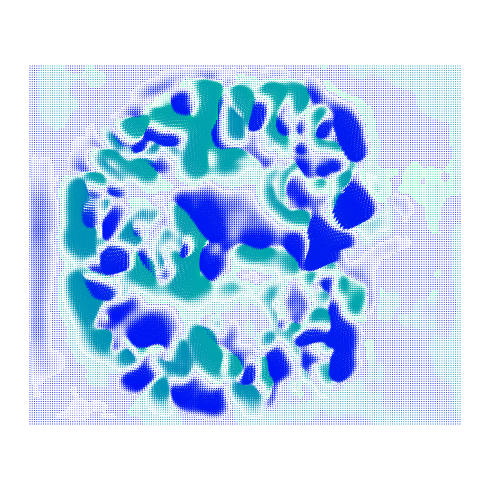

In [ ]:
import neurite as ne
warp=np.squeeze(warp_dic[0])

ne.plot.flow([warp], width=5);

# graph

dice = 0.7184263815392142, lc_dice = 0.6956209693854526, Simm = 0.713702366378145, Mix = 0.7191157992037079


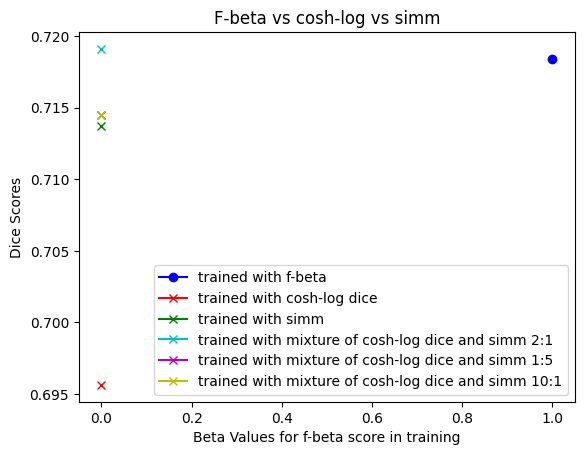

In [ ]:
dice_scorse = np.mean(dice_scores_dic[1])
lc_dice_scorse = np.mean(lc_dice_scores_dic)
Simm_dice_scores = np.mean(Simm_dice_scores_dic)
Mix_dice_scores = np.mean(Mix_dice_scores_dic)
Mix_dice_scores_005 = np.mean(Mix_dice_scores_dic_005)
Mix_dice_scores_0001 = np.mean(Mix_dice_scores_dic_0001)




print(f'dice = {dice_scorse}, lc_dice = {lc_dice_scorse}, Simm = {Simm_dice_scores}, Mix = {Mix_dice_scores}')
# Create a scatter plot
plt.plot(betas, dice_scorse, label='trained with f-beta', color='b', marker='o')
plt.plot([0], lc_dice_scorse, label='trained with cosh-log dice', color='r', marker='x')
plt.plot([0], Simm_dice_scores, label='trained with simm', color='g', marker='x')
plt.plot([0], Mix_dice_scores, label='trained with mixture of cosh-log dice and simm 2:1', color='c', marker='x')
plt.plot([0], Mix_dice_scores_005, label='trained with mixture of cosh-log dice and simm 1:5', color='m', marker='x')
plt.plot([0], Mix_dice_scores_005, label='trained with mixture of cosh-log dice and simm 10:1', color='y', marker='x')


plt.xlabel('Beta Values for f-beta score in training')
plt.ylabel('Dice Scores')
plt.title('F-beta vs cosh-log vs simm')
plt.legend()
plt.show()

